# Librerías:

In [226]:
import sys
import os
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import (month_plot, plot_acf, plot_pacf)
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
np.random.seed(0)
from scipy.stats import kurtosis, skew
from pathlib import Path

In [227]:
# Función de apoyo para hacer plots
def run_sequence_plot(x, y, title, xlabel="Tiempo", ylabel="Valores", ax=None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize=(10, 3.5))
    ax.plot(x, y, 'k-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(alpha=0.3)
    return ax

In [228]:
def fft_analysis(signal):
    # Linear detrending
    slope, intercept = np.polyfit(np.arange(len(signal)), signal, 1) # Ajuste recta
    trend = np.arange(len(signal)) * slope + intercept #tendencia lineal para cada punto
    detrended = signal - trend # Eliminación de la tendencia lineal  componentes dominantes
    fft_values = np.fft.fft(detrended) # frecuencias correspondientes a cada componente en la FFT
    frequencies = np.fft.fftfreq(len(fft_values)) #Valores de las frecuencias
    # Remove negative frequencies and sort
    positive_frequencies = frequencies[frequencies > 0]
    magnitudes = np.abs(fft_values)[frequencies > 0] #Intensidad de las comp. freq
    # Identify dominant frequency
    dominant_frequency = positive_frequencies[np.argmax(magnitudes)] #Indice freq.dom
    print(f"Dominant Frequency: {dominant_frequency:.3f}")
    # Convert frequency to period (e.g., days, weeks, months, etc.)
    dominant_period = 1 / dominant_frequency
    print(f"Dominant Period: {dominant_period:.2f} time units")
    return dominant_period, positive_frequencies, magnitudes

In [229]:
def temporal_features(signal):
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "max": np.max(signal),
        "min": np.min(signal),
        "ptp": np.ptp(signal),
        "kurtosis": kurtosis(signal),
        "skewness": skew(signal),
        "zero_crossings": np.sum(np.diff(np.sign(signal)) != 0)
    }

In [230]:
def sensor_mayor_incremento(
    df_features,
    feature,
    condition_fault,
    condition_normal="normal"
):
    """
    Devuelve el sensor con mayor incremento respecto a la condición normal
    para una característica dada.
    """

    deltas = []

    for sensor in df_features["sensor"].unique():
        df_s = (
            df_features[df_features["sensor"] == sensor]
            .set_index("condition")
        )

        val_normal = df_s.loc[condition_normal, feature]
        val_fault = df_s.loc[condition_fault, feature]

        delta = val_fault - val_normal

        deltas.append({
            "sensor": sensor,
            "delta": delta,
            "normal": val_normal,
            "fault": val_fault
        })

    df_deltas = pd.DataFrame(deltas).set_index("sensor")

    sensor_max = df_deltas["delta"].idxmax()
    max_delta = df_deltas.loc[sensor_max, "delta"]

    return sensor_max, max_delta, df_deltas

In [231]:
PATH=Path(r"C:\\Users\\Miguel\\Documents\\GitHub\\grupo1reto2\\")
csv_path = "temporal_features.csv"

# Dataset

In [232]:
# Nombres de los sensores (en el orden correcto)
sensor_names = [
    "tachometer",
    "acc_under_axial",
    "acc_under_radial",
    "acc_under_tangential",
    "acc_over_axial",
    "acc_over_radial",
    "acc_over_tangential",
    "microphone"
]

# Cargar CSV SIN header y asignar nombres
normal_12288 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced"/"normal"/"12.288.csv",
    header=None,
    names=sensor_names)

# Normal

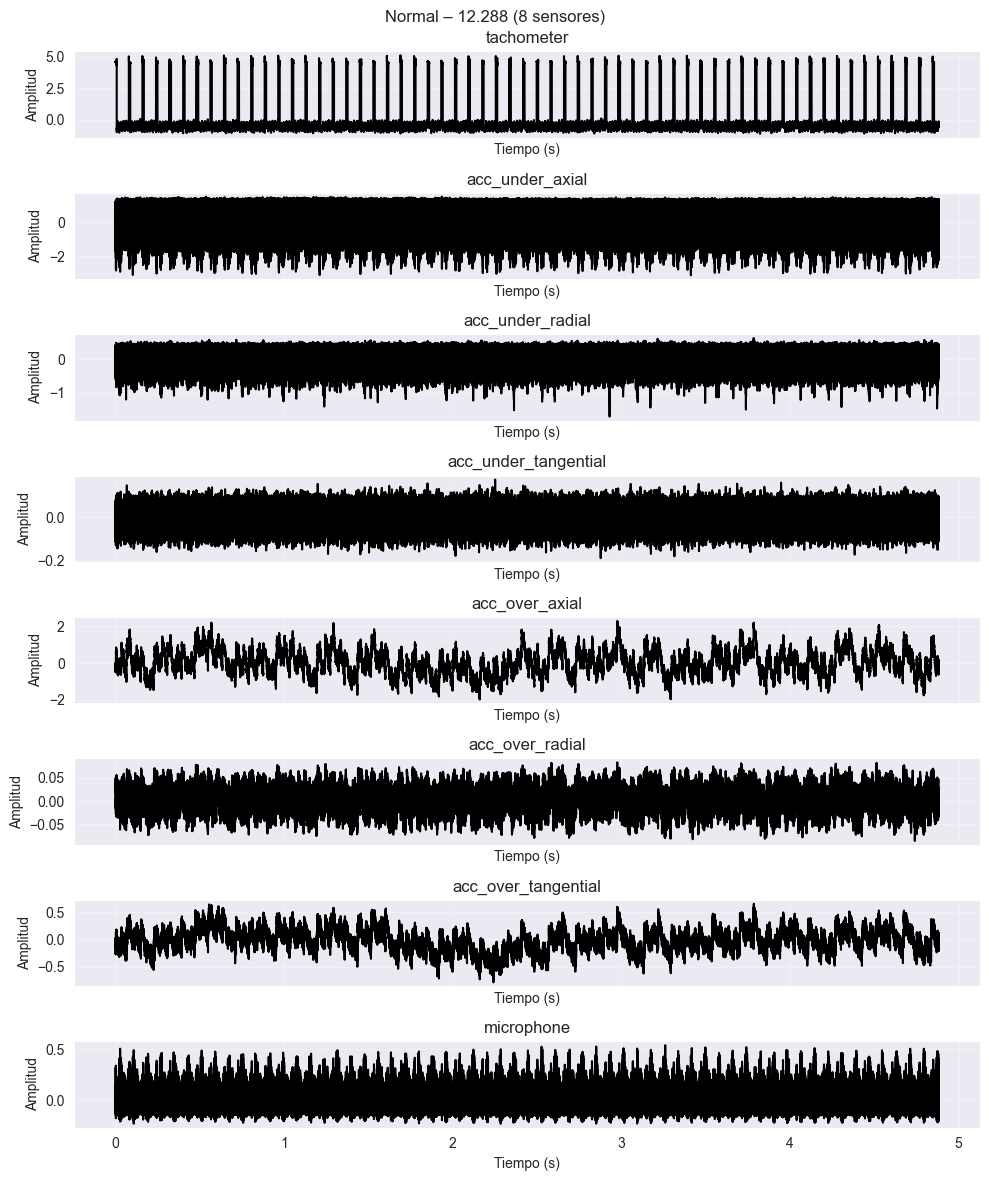

In [233]:
fs=51200

temporal = np.arange(len(normal_12288))/fs

# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(normal_12288.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, normal_12288.columns):
    run_sequence_plot(
        temporal,
        normal_12288[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Normal – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

# Horizontal misaligment:

In [234]:
# Cargar CSV SIN header y asignar nombres
hor_misalig_05 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced" / "horizontal-misalignment" / "0.5mm" / "12.288.csv",
    header=None,
    names=sensor_names)

hor_misalig_10 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced" / "horizontal-misalignment" / "1.0mm" / "12.288.csv",
    header=None,
    names=sensor_names)

hor_misalig_15 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced" / "horizontal-misalignment" / "1.5mm" / "12.288.csv",
    header=None,
    names=sensor_names)

hor_misalig_20 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced" / "horizontal-misalignment" / "2.0mm" / "12.288.csv",
    header=None,
    names=sensor_names)

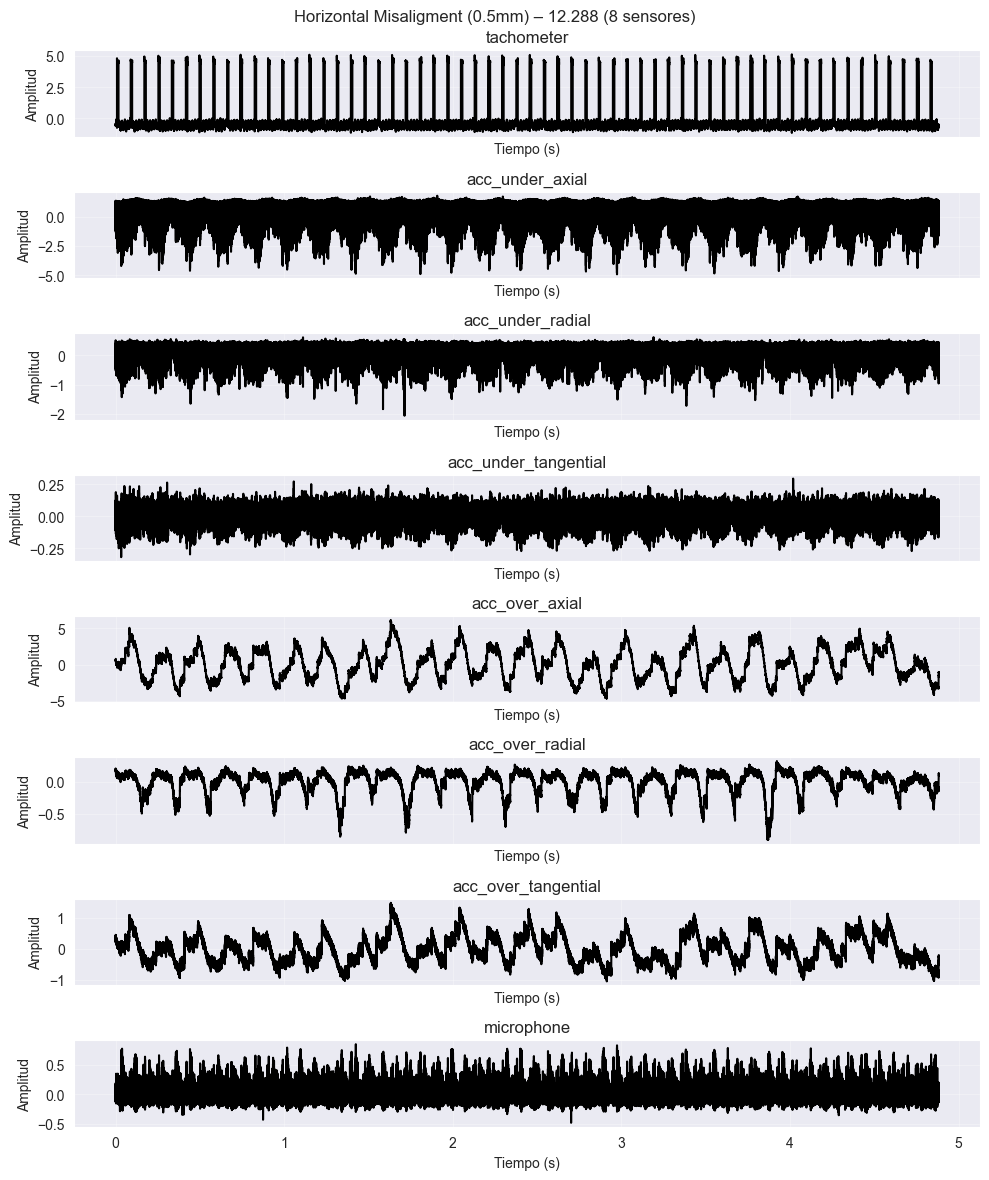

In [235]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(hor_misalig_05.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, hor_misalig_05.columns):
    run_sequence_plot(
        temporal,
        hor_misalig_05[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Horizontal Misaligment (0.5mm) – 12.288 (8 sensores)")
plt.tight_layout()
plt.show()

## Compación normal vs horizontal misaligment

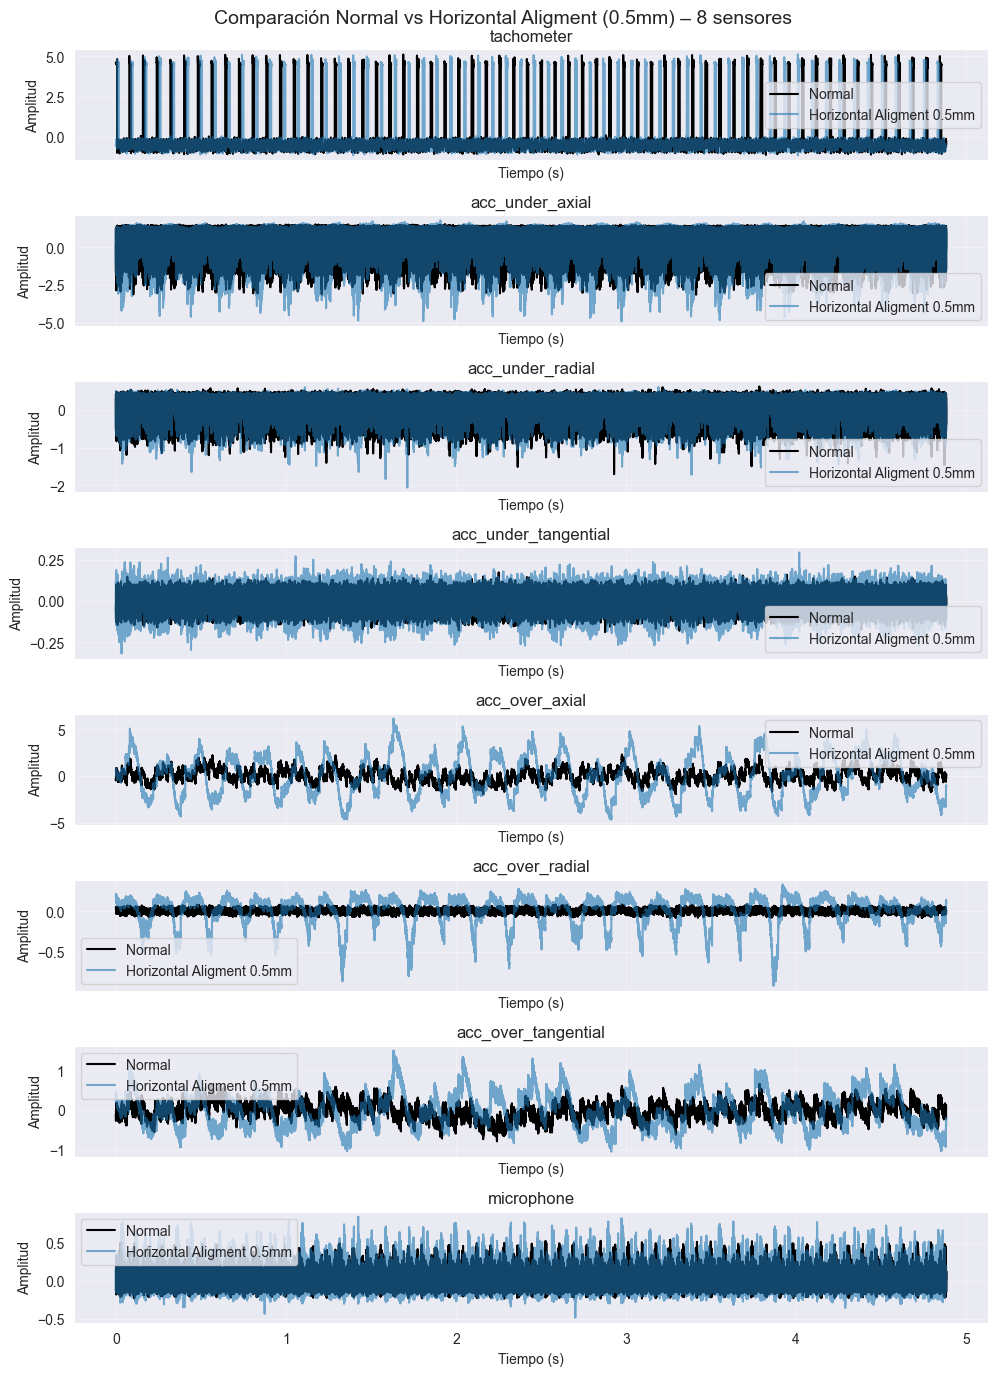

In [236]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        hor_misalig_05[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Horizontal Aligment 0.5mm"])

fig.suptitle("Comparación Normal vs Horizontal Aligment (0.5mm) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [237]:
signals_by_condition = {
    "normal": normal_12288,
    "horizontal_0.5": hor_misalig_05,
    "horizontal_1.0": hor_misalig_10,
    "horizontal_1.5": hor_misalig_15,
    "horizontal_2.0": hor_misalig_20
}

In [238]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)

if os.path.exists(csv_path):
    df_features.to_csv(csv_path, mode='a', header=False, index=False)
else:
    df_features.to_csv(csv_path, index=False)

df_features

mean       std       rms       max       min       ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.107800 -1.125900   6.23370  4.304473   
1   0.002844  1.588314  1.588316  5.114900 -1.150800   6.26570  4.261619   
2  -0.000348  1.581787  1.581787  5.088500 -1.166900   6.25540  4.344647   
3   0.001224  1.583230  1.583230  5.109000 -1.117800   6.22680  4.331515   
4  -0.001437  1.579752  1.579753  5.088300 -1.149100   6.23740  4.370045   
5  -0.002661  0.979174  0.979178  1.528400 -3.142900   4.67130 -1.065732   
6   0.010533  1.114815  1.114865  1.766000 -4.907000   6.67300 -0.203988   
7   0.005574  1.020265  1.020280  1.542900 -4.295600   5.83850 -0.484146   
8   0.003652  0.938739  0.938746  1.542300 -3.342800   4.88510 -0.889810   
9   0.002840  1.138557  1.138560  1.907700 -5.130800   7.03850 -0.375033   
10 -0.000632  0.307370  0.307371  0.624310 -1.709000   2.33331 -0.725945   
11  0.002472  0.305721  0.305731  0.610280 -2.061900   2.67218 -0.174034   
12  0.000024  0.288051  0.288051  0.846730 -1.637600   2.48433 -0.537445   
13 -0.000411  0.301393  0.301393  0.746290 -1.361800   2.10809 -0.808875   
14  0.013718  0.394403  0.394641  0.666440 -2.075100   2.74154 -0.169058   
15  0.000324  0.044809  0.044810  0.173330 -0.188460   0.36179 -0.377439   
16  0.002127  0.058942  0.058981  0.293430 -0.317730   0.61116  0.295870   
17  0.000295  0.061029  0.061029  0.586320 -0.529910   1.11623  0.188607   
18  0.000230  0.051763  0.051764  0.299790 -0.280430   0.58022 -0.030303   
19  0.000334  0.076342  0.076343  0.384760 -0.560560   0.94532  0.632635   
20  0.031088  0.668105  0.668827  2.280100 -1.976300   4.25640 -0.387141   
21  0.040626  2.124300  2.124689  6.124400 -4.681700  10.80610 -0.848509   
22  0.017241  1.078368  1.078506  3.123800 -3.506300   6.63010 -0.401838   
23 -0.032791  0.904211  0.904805  3.059400 -2.384700   5.44410 -0.255969   
24  0.070876  2.150902  2.152069  3.465200 -5.603400   9.06860 -1.006166   
25  0.003156  0.030200  0.030364  0.082952 -0.085668   0.16862 -0.767459   
26  0.004085  0.183408  0.183453  0.324830 -0.914280   1.23911  2.246780   
27  0.004084  0.179460  0.179507  0.472210 -1.063300   1.53551  1.274990   
28  0.002530  0.037024  0.037110  0.108190 -0.110160   0.21835 -0.503455   
29  0.019764  0.365311  0.365845  0.635390 -0.978810   1.61420 -0.869231   
30  0.004970  0.197512  0.197575  0.655470 -0.790590   1.44606 -0.250981   
31  0.002572  0.433117  0.433125  1.489300 -1.048600   2.53790 -0.550439   
32  0.003195  0.190429  0.190456  0.648890 -0.709440   1.35833 -0.385537   
33 -0.032396  0.300454  0.302195  1.175200 -1.030700   2.20590 -0.001922   
34  0.116081  1.918331  1.921840  4.836300 -3.539900   8.37620 -1.128110   
35  0.008016  0.112139  0.112425  0.540400 -0.233760   0.77416  0.065309   
36  0.017537  0.144844  0.145901  0.843330 -0.483620   1.32695  0.824592   
37  0.018609  0.145770  0.146953  0.856690 -0.338200   1.19489  0.689134   
38  0.008150  0.121138  0.121411  0.626730 -0.277770   0.90450  0.839907   
39  0.015883  0.133057  0.134001  0.911500 -0.309800   1.22130  2.013051   

    skewness  zero_crossings                sensor       condition  
0   2.500403             145            tachometer          normal  
1   2.492287             144            tachometer  horizontal_0.5  
2   2.508516             138            tachometer  horizontal_1.0  
3   2.505950             144            tachometer  horizontal_1.5  
4   2.513654             146            tachometer  horizontal_2.0  
5  -0.296534          205848       acc_under_axial          normal  
6  -0.724941          177592       acc_under_axial  horizontal_0.5  
7  -0.570366          191478       acc_under_axial  horizontal_1.0  
8  -0.373543          202020       acc_under_axial  horizontal_1.5  
9  -0.733271          157395       acc_under_axial  horizontal_2.0  
10 -0.391702          203768      acc_under_radial          normal  
11 -0.680915          182886      acc_under_radial  horizontal_

In [239]:
features = [
    "mean",
    "std",
    "rms",
    "max",
    "min",
    "ptp",
    "kurtosis",
    "skewness",
    "zero_crossings"
]

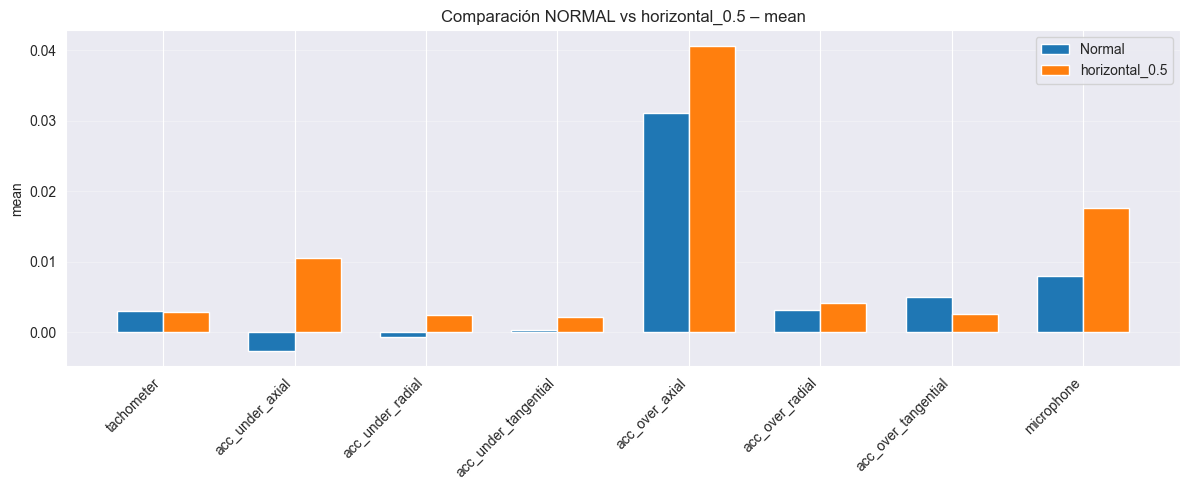

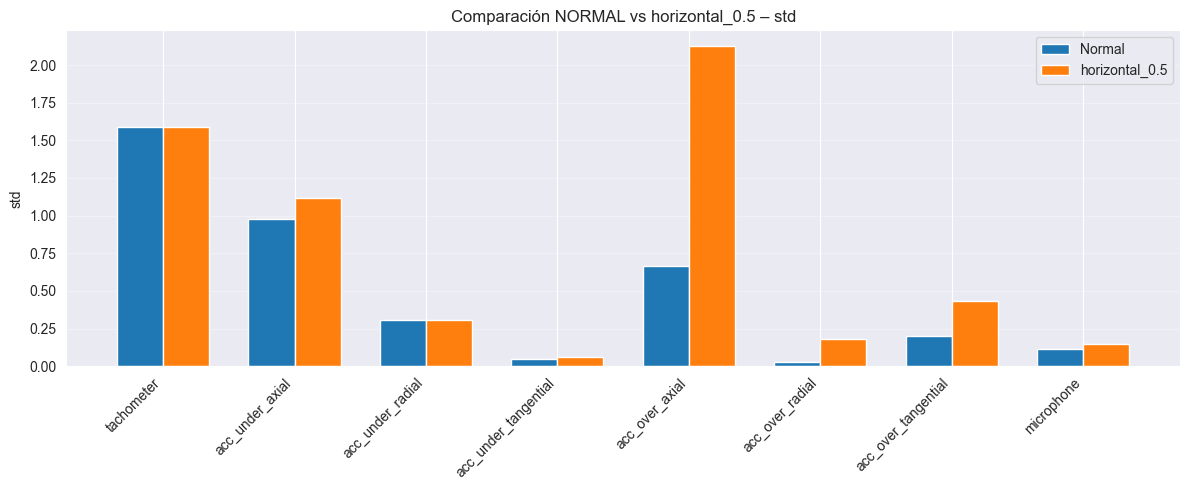

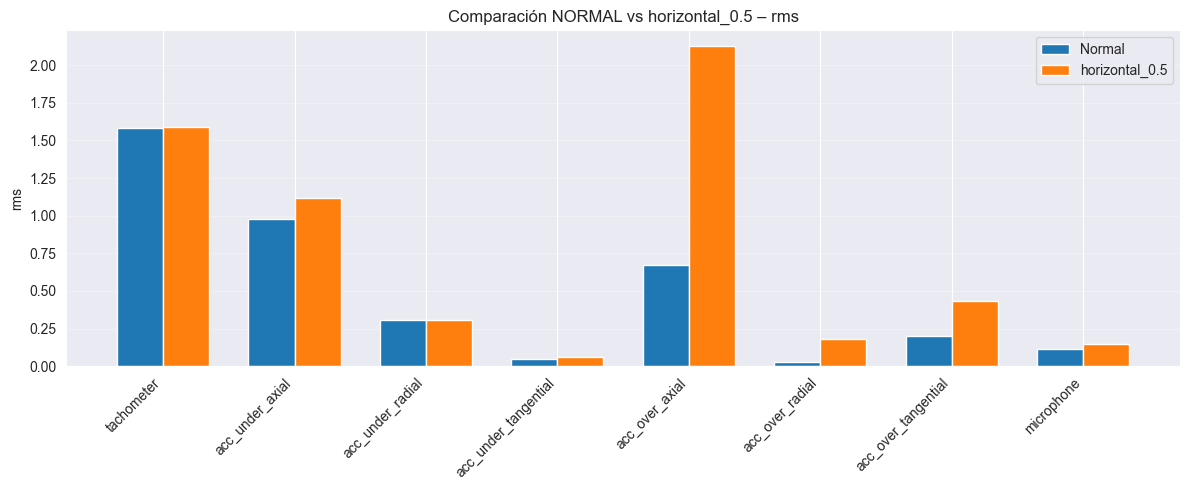

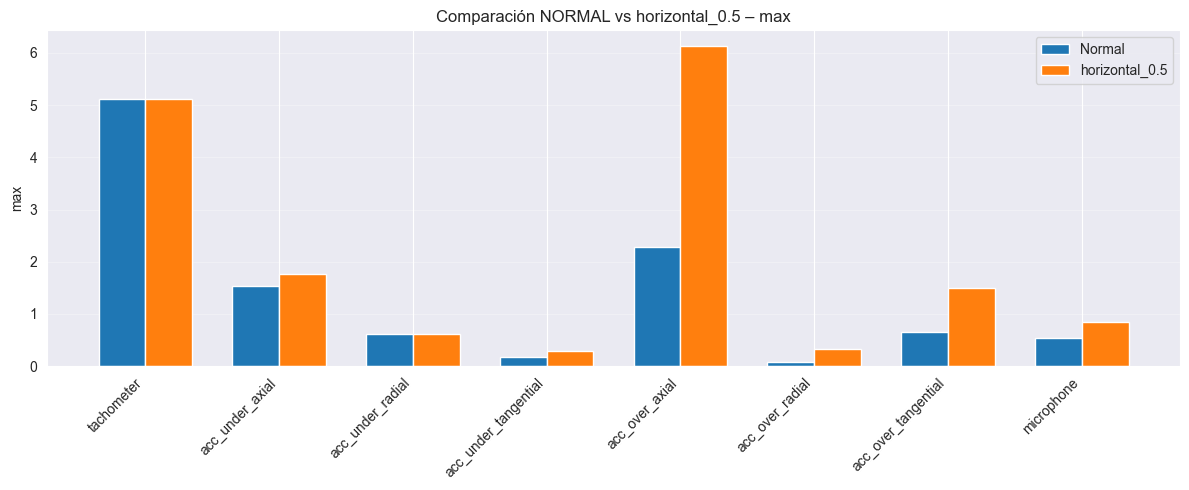

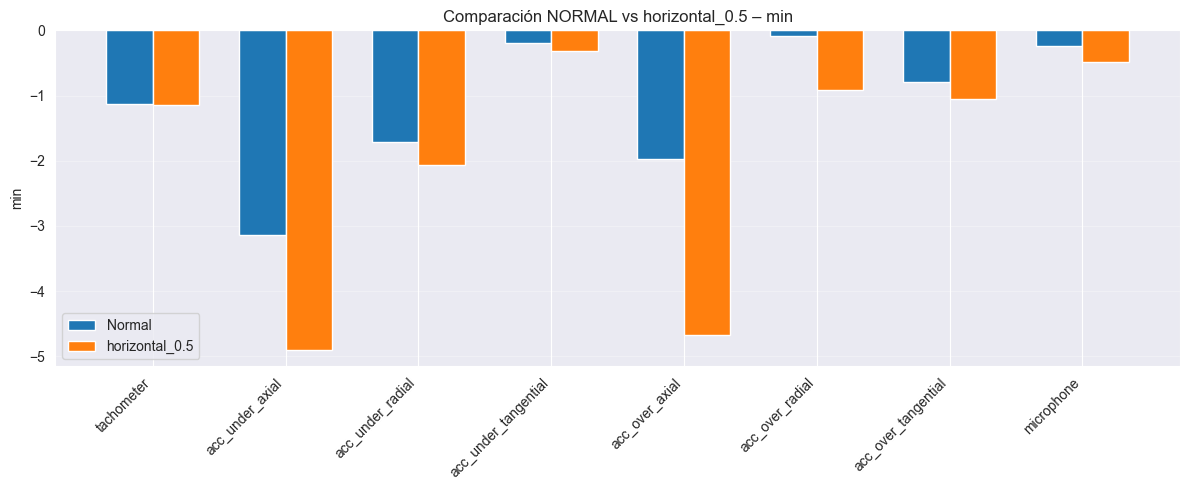

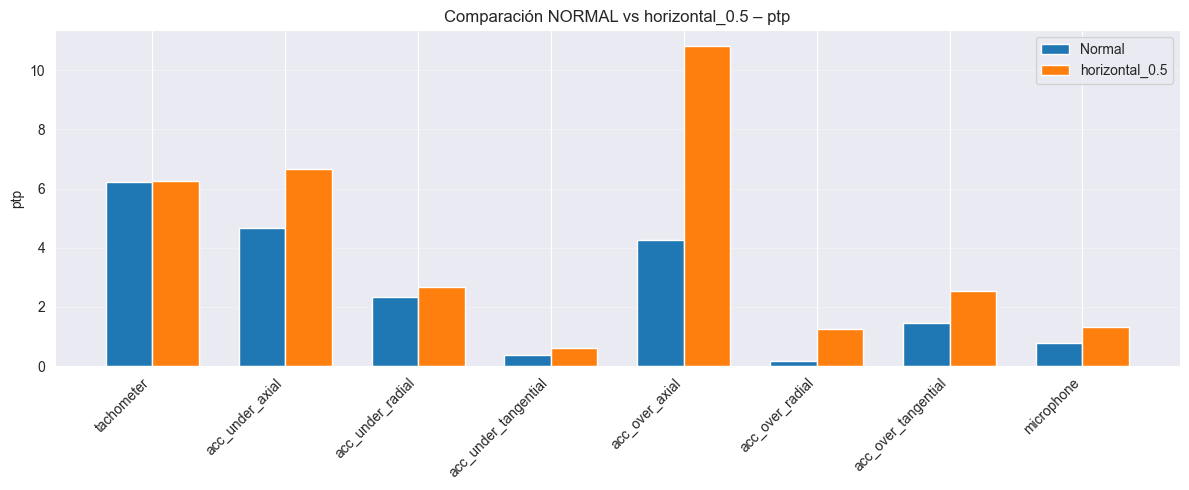

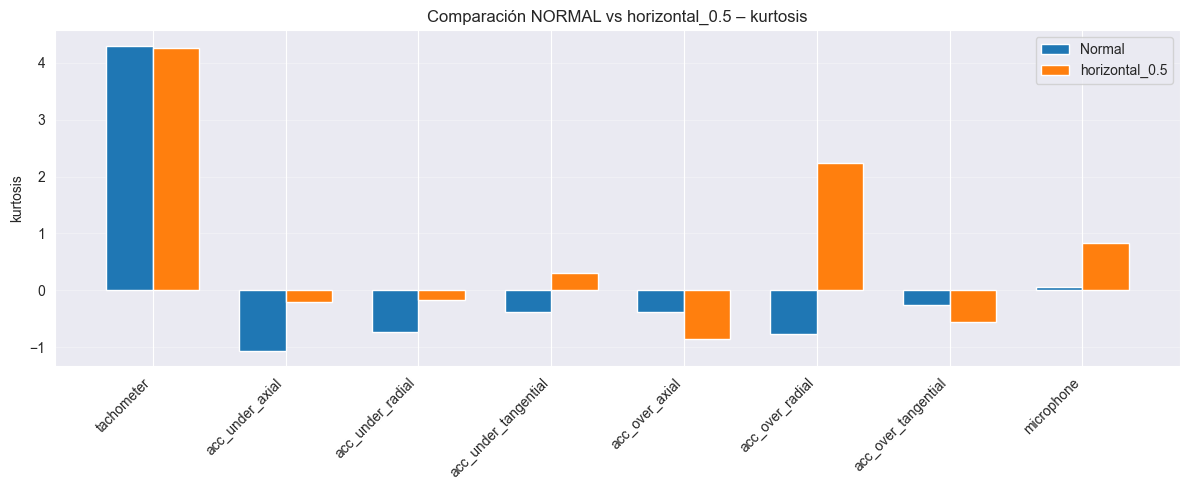

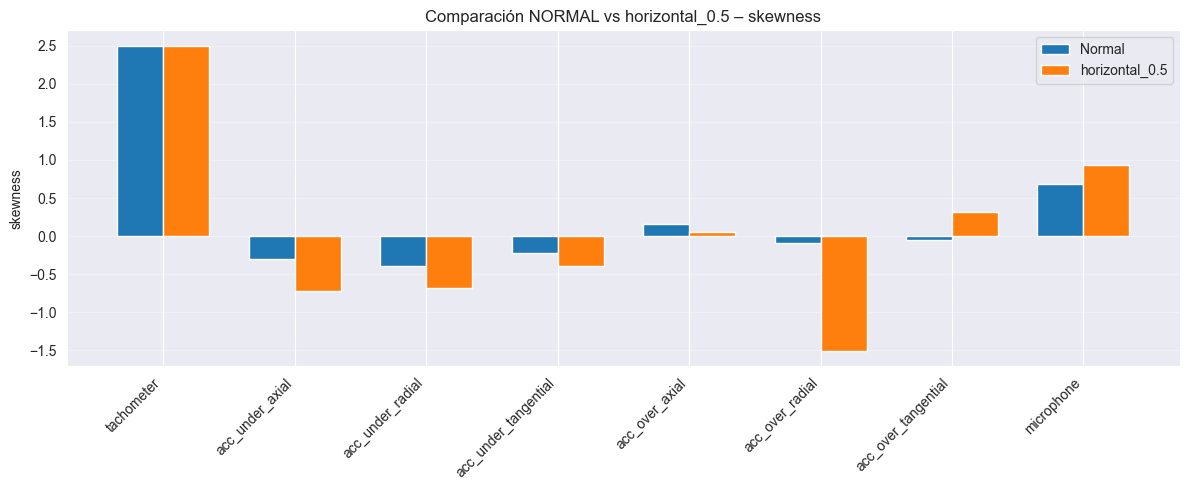

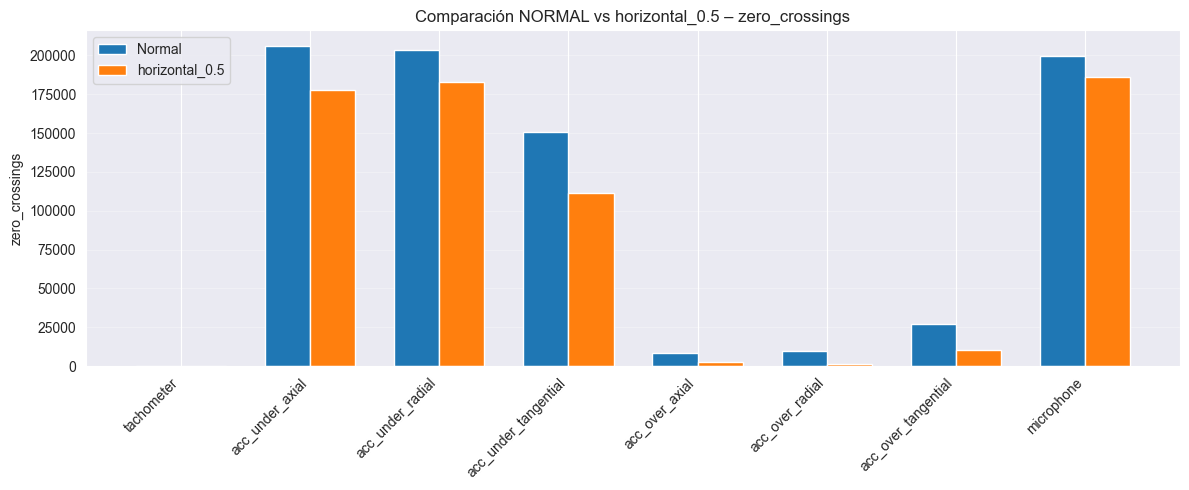

In [240]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["horizontal_0.5", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="horizontal_0.5")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs horizontal_0.5 – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [241]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="horizontal_0.5"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.013193270359454792

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 1.4561958863047324

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 1.455861437523299

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 3.8442999999999996

Característica: min
Sensor con mayor incremento: tachometer
Incremento: -0.024900000000000144

Característica: ptp
Sensor con mayor incremento: acc_over_axial
Incremento: 6.5497000000000005

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 3.014239069231305

Característica: skewness
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.3626915221771658

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: -1



# Vertical misaligment

In [242]:
# Cargar CSV SIN header y asignar nombres
ver_misalig_051 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "0.51mm" / "12.4928.csv",
    header=None,
    names=sensor_names)

ver_misalig_063 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "0.63mm" / "12.4928.csv",
    header=None,
    names=sensor_names)

ver_misalig_127 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "1.27mm" / "12.0832.csv",
    header=None,
    names=sensor_names)

ver_misalig_140 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "1.40mm" / "12.0832.csv",
    header=None,
    names=sensor_names)

ver_misalig_178 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "1.78mm" / "12.4928.csv",
    header=None,
    names=sensor_names)

ver_misalig_190 = pd.read_csv(
    PATH / "bearing_fault_detection_reduced" / "vertical-misalignment" / "1.90mm" / "12.0832.csv",
    header=None,
    names=sensor_names)

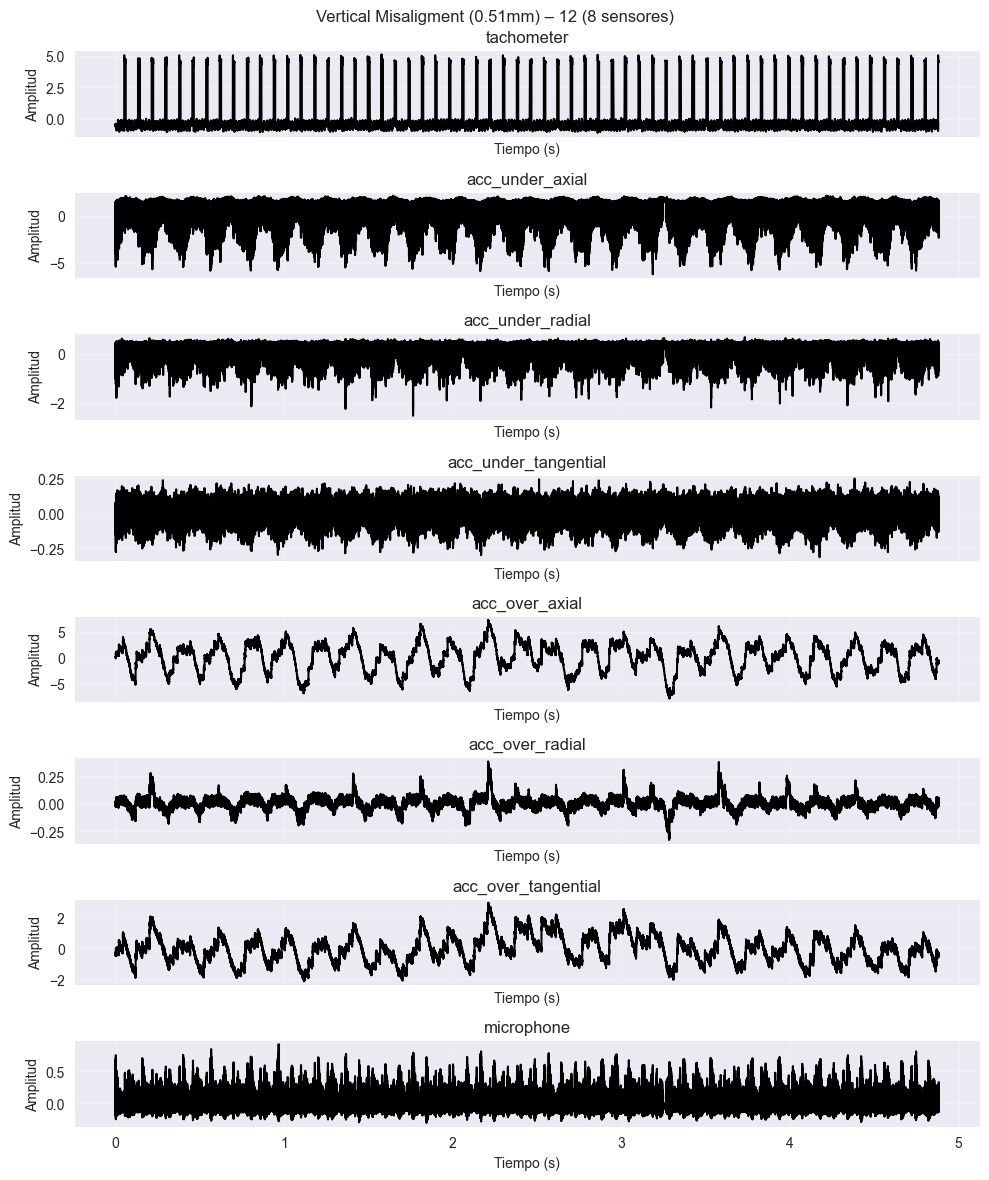

In [243]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(ver_misalig_051.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, ver_misalig_051.columns):
    run_sequence_plot(
        temporal,
        ver_misalig_051[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Vertical Misaligment (0.51mm) – 12 (8 sensores)")
plt.tight_layout()
plt.show()

## Compación normal vs vertical misaligment

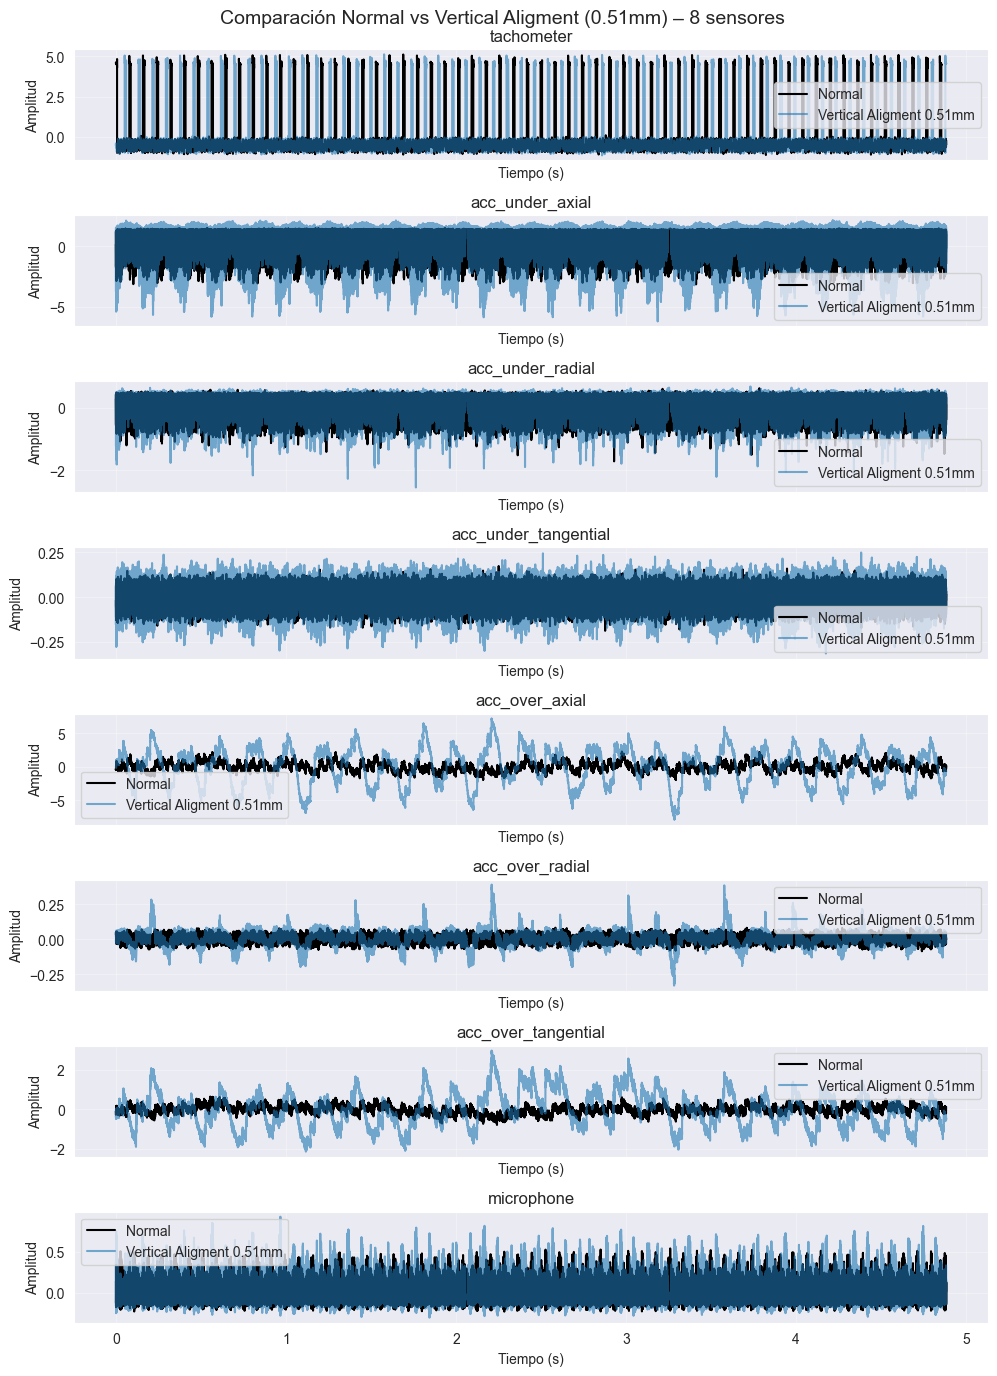

In [244]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        ver_misalig_051[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Vertical Aligment 0.51mm"])

fig.suptitle("Comparación Normal vs Vertical Aligment (0.51mm) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [245]:
signals_by_condition = {
    "normal": normal_12288,
    "vertical_0.51": ver_misalig_051,
    "vertical_0.63": ver_misalig_063,
    "vertical_1.27": ver_misalig_127,
    "vertical_1.40": ver_misalig_140,
    "vertical_1.78": ver_misalig_178,
    "vertical_1.90": ver_misalig_190
}

In [246]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)

df_features

mean       std       rms       max       min       ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.107800 -1.125900   6.23370  4.304473   
1  -0.001608  1.583158  1.583159  5.114900 -1.148300   6.26320  4.333908   
2  -0.000214  1.588067  1.588067  5.114900 -1.255900   6.37080  4.273197   
3  -0.001514  1.582864  1.582864  5.114900 -1.169000   6.28390  4.335703   
4   0.000113  1.585370  1.585370  5.114900 -1.121500   6.23640  4.310361   
5  -0.000246  1.592251  1.592251  5.114900 -1.247200   6.36210  4.226620   
6  -0.003334  1.585010  1.585013  5.114900 -1.165300   6.28020  4.313639   
7  -0.002661  0.979174  0.979178  1.528400 -3.142900   4.67130 -1.065732   
8   0.025476  1.428717  1.428944  2.150400 -6.210200   8.36060 -0.056997   
9   0.002405  1.071219  1.071222  1.992600 -3.692600   5.68520 -0.966279   
10 -0.001754  0.995848  0.995849  2.044100 -3.631300   5.67540 -0.853526   
11  0.000137  1.121941  1.121941  2.372200 -4.146500   6.51870 -0.822395   
12  0.003825  1.210427  1.210433  2.391400 -4.571500   6.96290 -0.800060   
13 -0.003637  1.087110  1.087116  2.237400 -4.295900   6.53330 -0.790945   
14 -0.000632  0.307370  0.307371  0.624310 -1.709000   2.33331 -0.725945   
15  0.001568  0.359941  0.359944  0.680110 -2.541600   3.22171  0.007723   
16 -0.000203  0.323835  0.323835  0.624830 -1.794800   2.41963 -0.544259   
17  0.000776  0.336297  0.336298  0.744370 -1.642900   2.38727 -0.750118   
18 -0.000218  0.347787  0.347787  0.712500 -1.727000   2.43950 -0.828654   
19 -0.000443  0.369824  0.369825  0.878040 -1.638000   2.51604 -0.838125   
20 -0.000275  0.351728  0.351728  0.771440 -1.509400   2.28084 -0.800210   
21  0.000324  0.044809  0.044810  0.173330 -0.188460   0.36179 -0.377439   
22  0.001002  0.060904  0.060912  0.248670 -0.315160   0.56383  0.319906   
23  0.000329  0.057881  0.057882  0.354140 -0.284700   0.63884  0.031069   
24  0.001277  0.071331  0.071343  0.394630 -0.456420   0.85105  0.544882   
25 -0.000016  0.076034  0.076034  0.369120 -0.409340   0.77846  0.400087   
26  0.000338  0.078535  0.078536  0.440340 -0.421650   0.86199  0.482875   
27 -0.000166  0.077106  0.077106  0.357920 -0.465560   0.82348  0.585553   
28  0.031088  0.668105  0.668827  2.280100 -1.976300   4.25640 -0.387141   
29  0.026747  2.716943  2.717075  7.224300 -7.920000  15.14430 -0.642313   
30  0.048036  1.346774  1.347630  4.496000 -2.964000   7.46000 -0.242914   
31  0.005730  0.276208  0.276268  0.612530 -0.772680   1.38521 -1.031188   
32  0.009182  0.196920  0.197134  0.459970 -0.624980   1.08495 -0.796684   
33  0.016777  0.177660  0.178450  0.438190 -0.631360   1.06955 -0.588704   
34  0.006662  0.161214  0.161351  0.411780 -0.423310   0.83509 -1.021258   
35  0.003156  0.030200  0.030364  0.082952 -0.085668   0.16862 -0.767459   
36  0.006873  0.062392  0.062769  0.387940 -0.329780   0.71772  3.016592   
37  0.003572  0.065816  0.065913  0.539490 -0.171400   0.71089  8.668265   
38  0.003199  0.056942  0.057032  0.160140 -0.156060   0.31620 -0.718619   
39  0.003932  0.044653  0.044825  0.130050 -0.135840   0.26589 -0.468290   
40  0.009427  0.041840  0.042889  0.130680 -0.130600   0.26128 -0.456497   
41  0.003065  0.040945  0.041060  0.126360 -0.110520   0.23688 -0.581998   
42  0.004970  0.197512  0.197575  0.655470 -0.790590   1.44606 -0.250981   
43 -0.020129  0.881105  0.881335  2.964600 -2.139000   5.10360 -0.436761   
44  0.020678  0.651032  0.651360  2.602100 -1.574200   4.17630  0.036608   
45  0.048023  1.132789  1.133806  3.490900 -2.516000   6.00690 -0.574541   
46  0.047732  1.038484  1.039581  3.469200 -2.408800   5.87800 -0.235494   
47  0.086170  1.028829  1.032431  3.348300 -2.858100   6.20640 -0.450076   
48  0.163292  1.457806  1.466923  5.168500 -2.585000   7.75350 -0.232421   
49  0.008016  0.112139  0.112425  0.540400 -0.233760   0.77416  0.065309   
50  0.020090  0.133510  0.135013  0.928830 -0.307750   1.23658  1.227993   
51  0.005493  0.097685  0.097840  0.532220 -0.224780   0

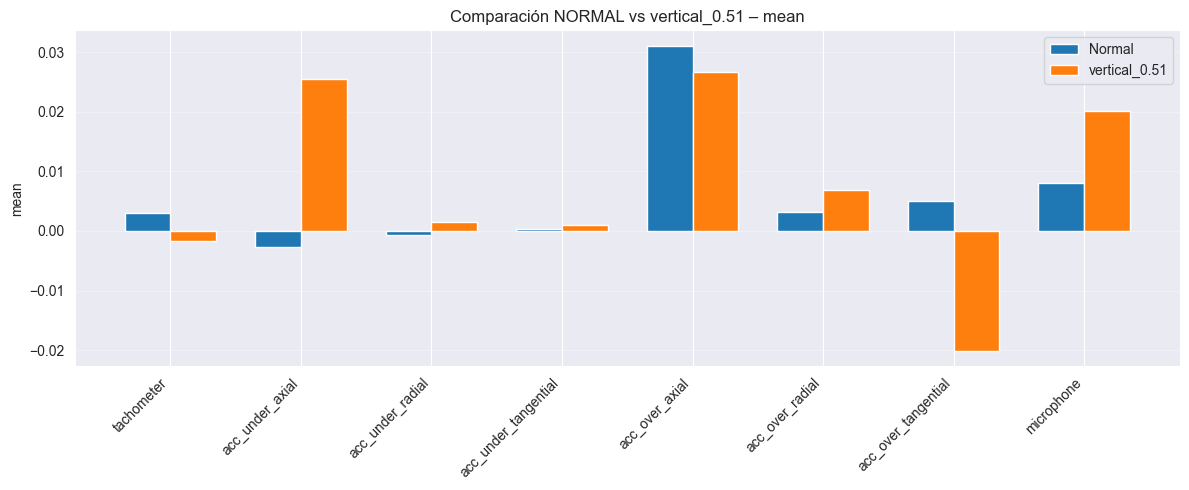

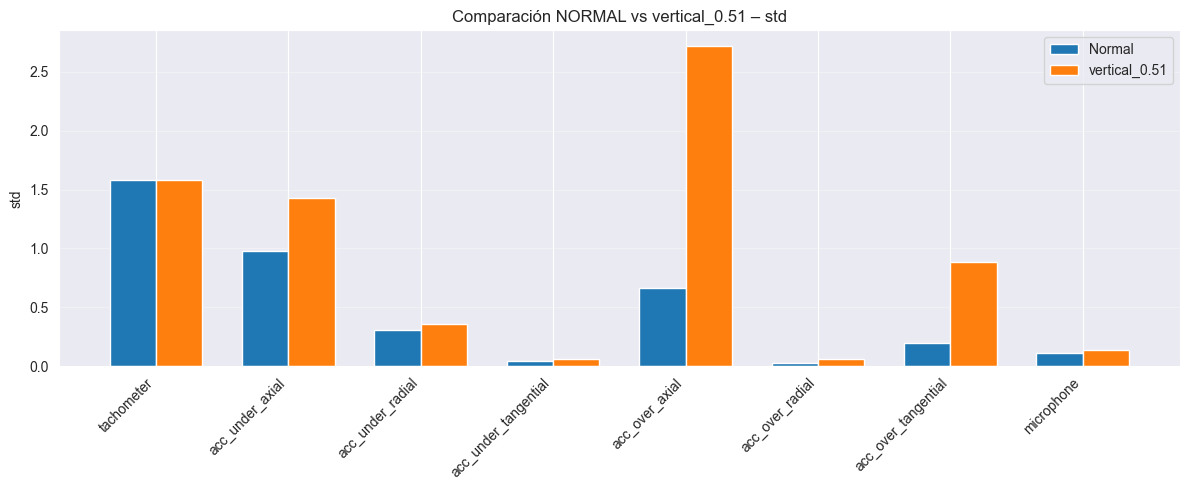

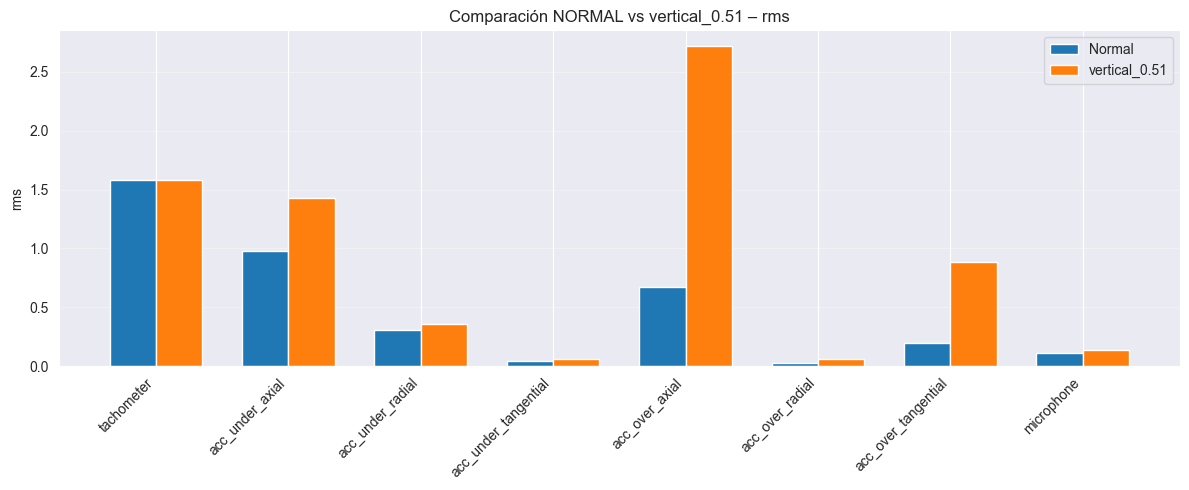

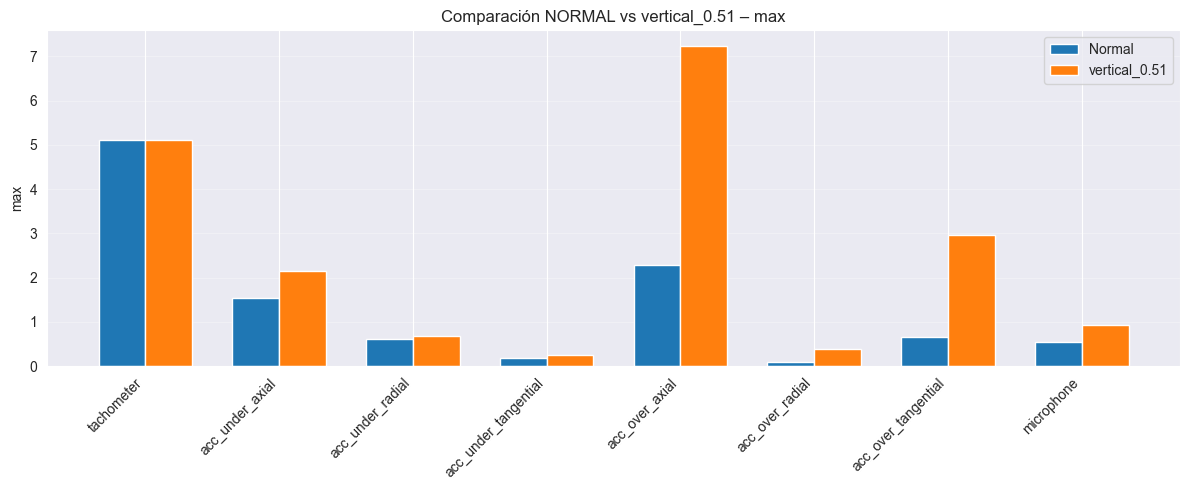

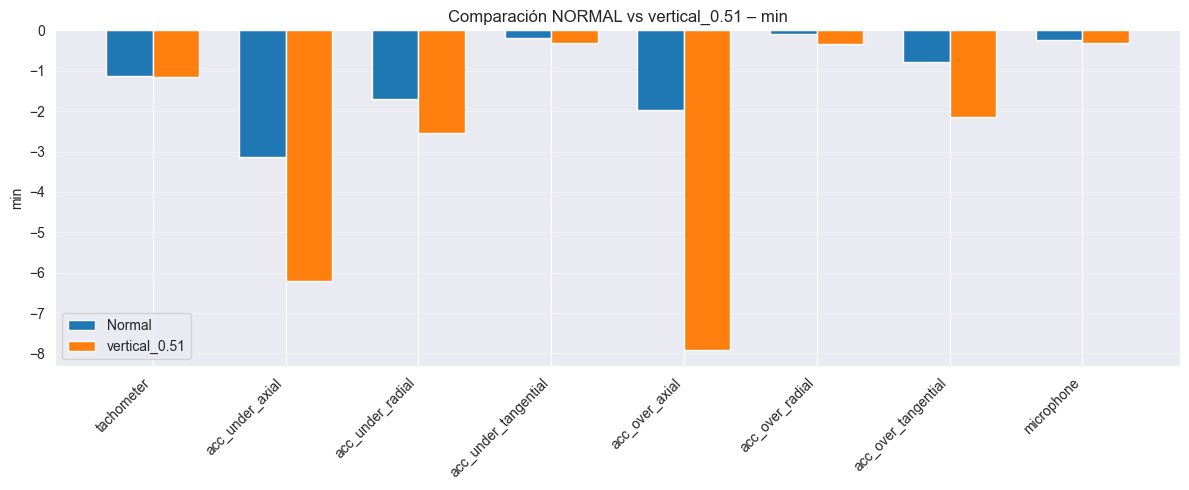

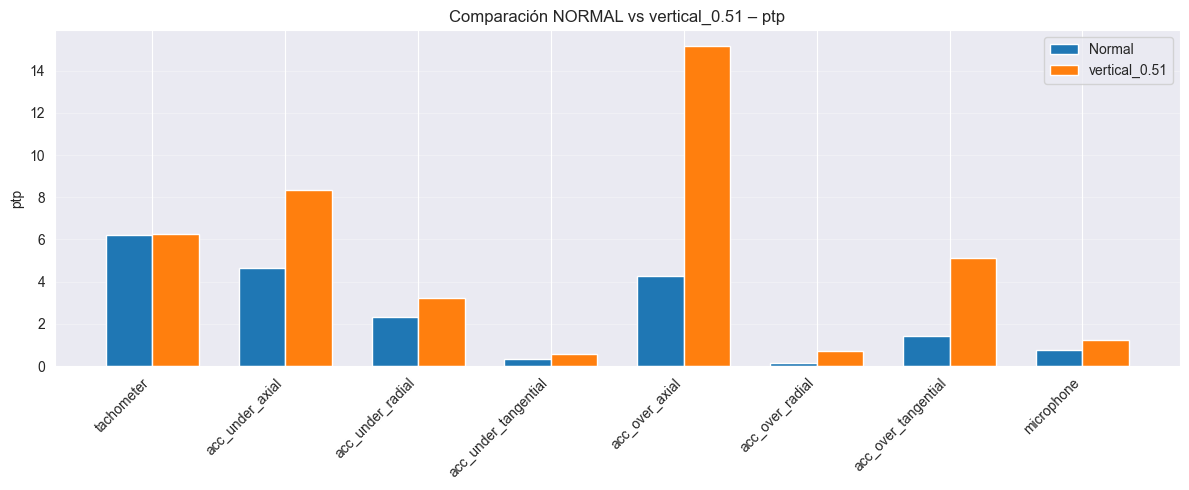

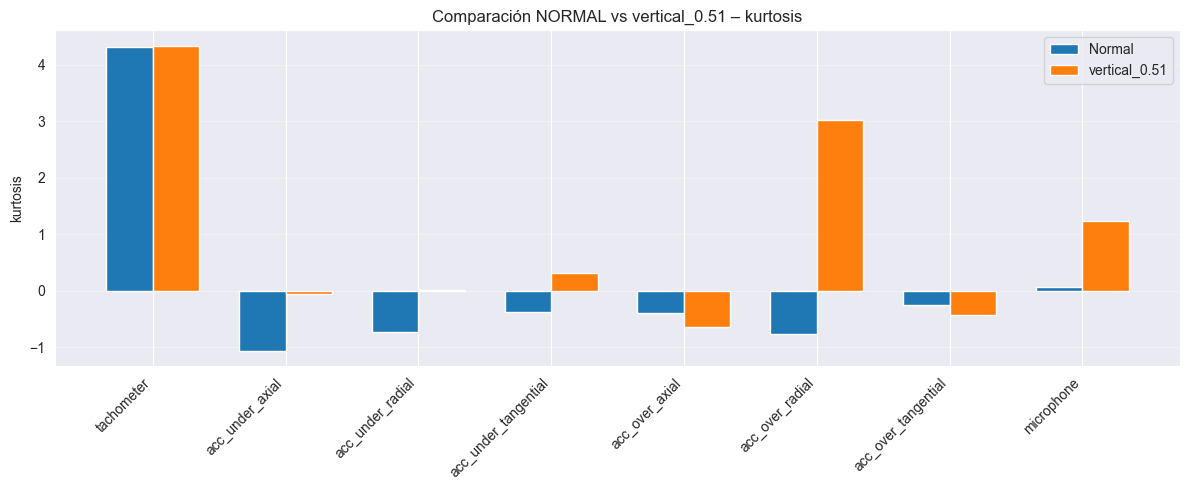

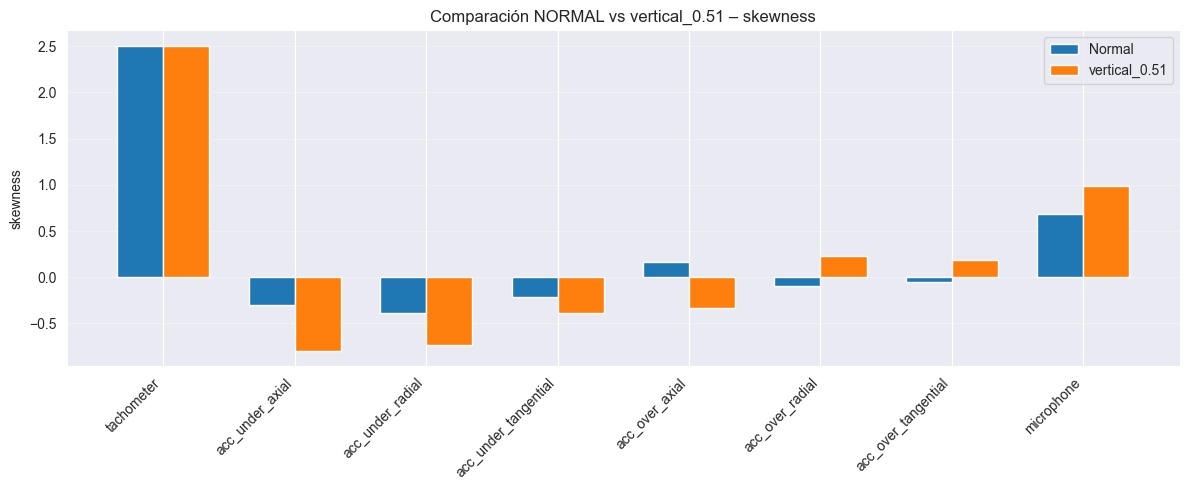

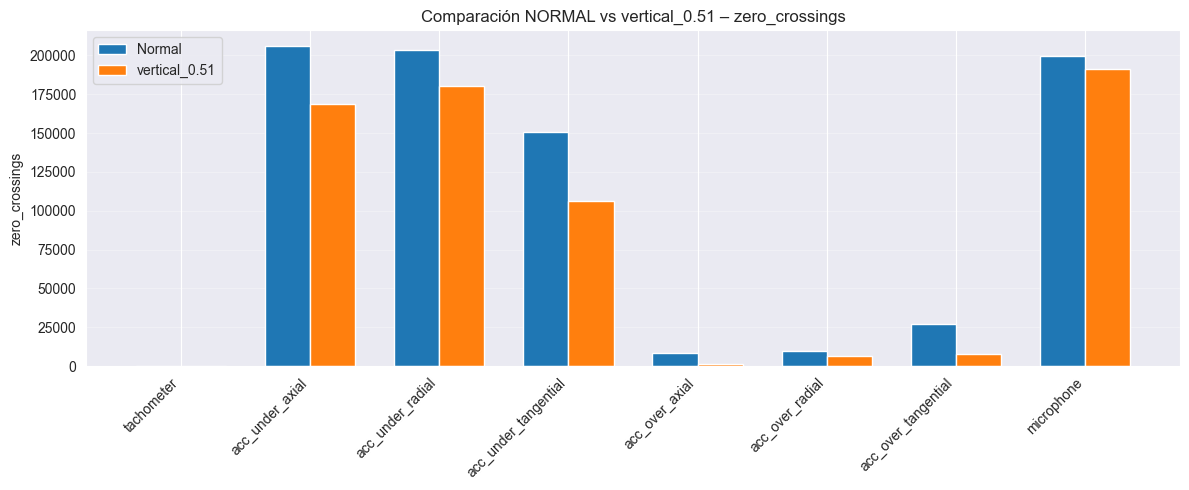

In [247]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["vertical_0.51", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="vertical_0.51")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs vertical_0.51 – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [248]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="vertical_0.51"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.028136311251076008

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 2.048838467187176

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 2.0482472371943237

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 4.9442

Característica: min
Sensor con mayor incremento: tachometer
Incremento: -0.022400000000000198

Característica: ptp
Sensor con mayor incremento: acc_over_axial
Incremento: 10.887900000000002

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 3.78405139949425

Característica: skewness
Sensor con mayor incremento: acc_over_radial
Incremento: 0.32383859833407186

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: -4



# Imbalance

In [249]:
# Cargar CSV SIN header y asignar nombres
im_6g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"6g" / "13.9264.csv",
    header=None,
    names=sensor_names)

im_10g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"10g" / "13.9264.csv",
    header=None,
    names=sensor_names)

im_15g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"15g" / "13.312.csv",
    header=None,
    names=sensor_names)

im_20g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"20g" / "13.312.csv",
    header=None,
    names=sensor_names)

im_25g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"25g" / "12.288.csv",
    header=None,
    names=sensor_names)

im_30g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"30g" / "12.0832.csv",
    header=None,
    names=sensor_names)

im_35g_139264 = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"imbalance"/"35g" / "12.0832.csv",
    header=None,
    names=sensor_names)

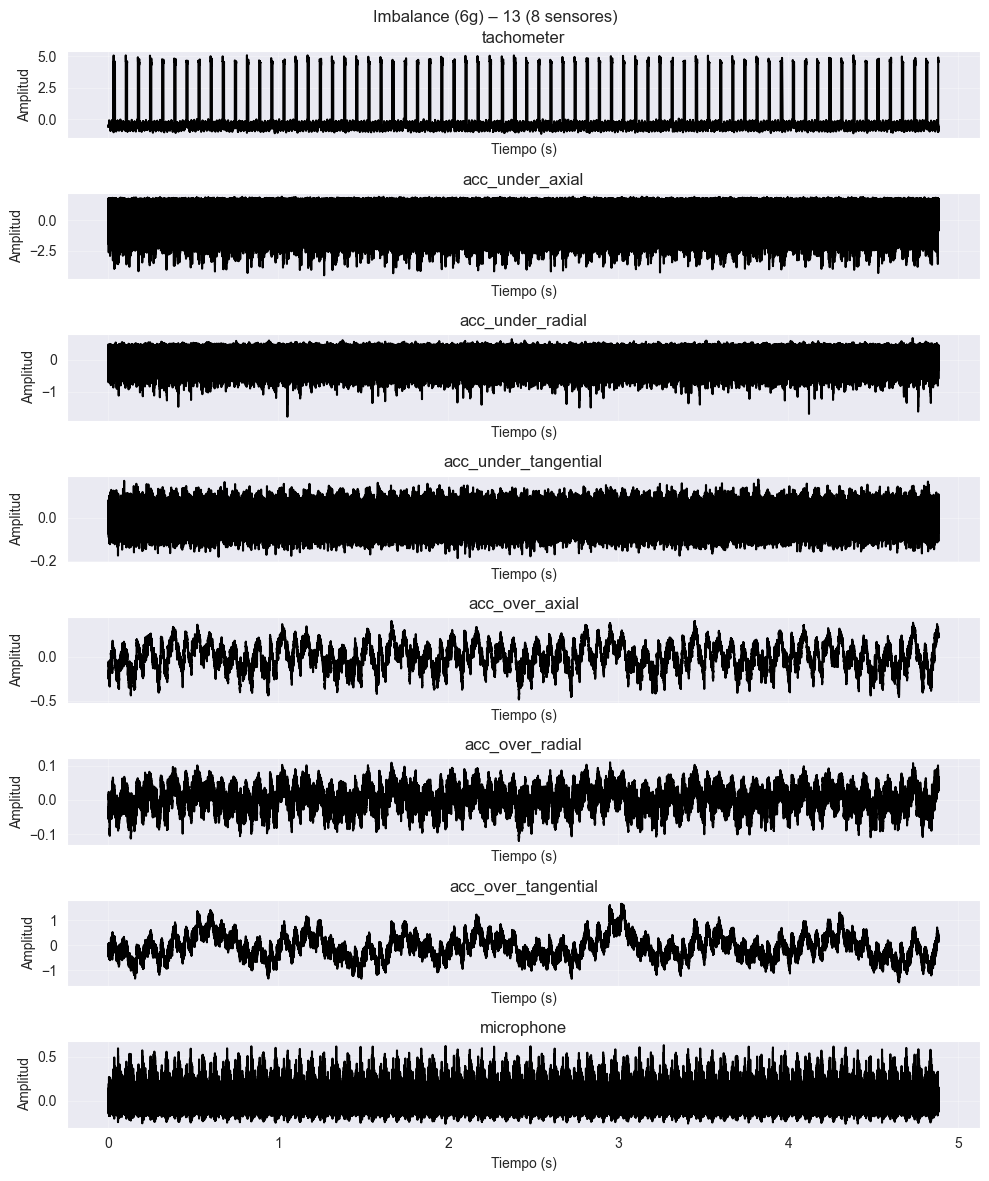

In [250]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(im_6g_139264.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, im_6g_139264.columns):
    run_sequence_plot(
        temporal,
        im_6g_139264[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Imbalance (6g) – 13 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs imbalance

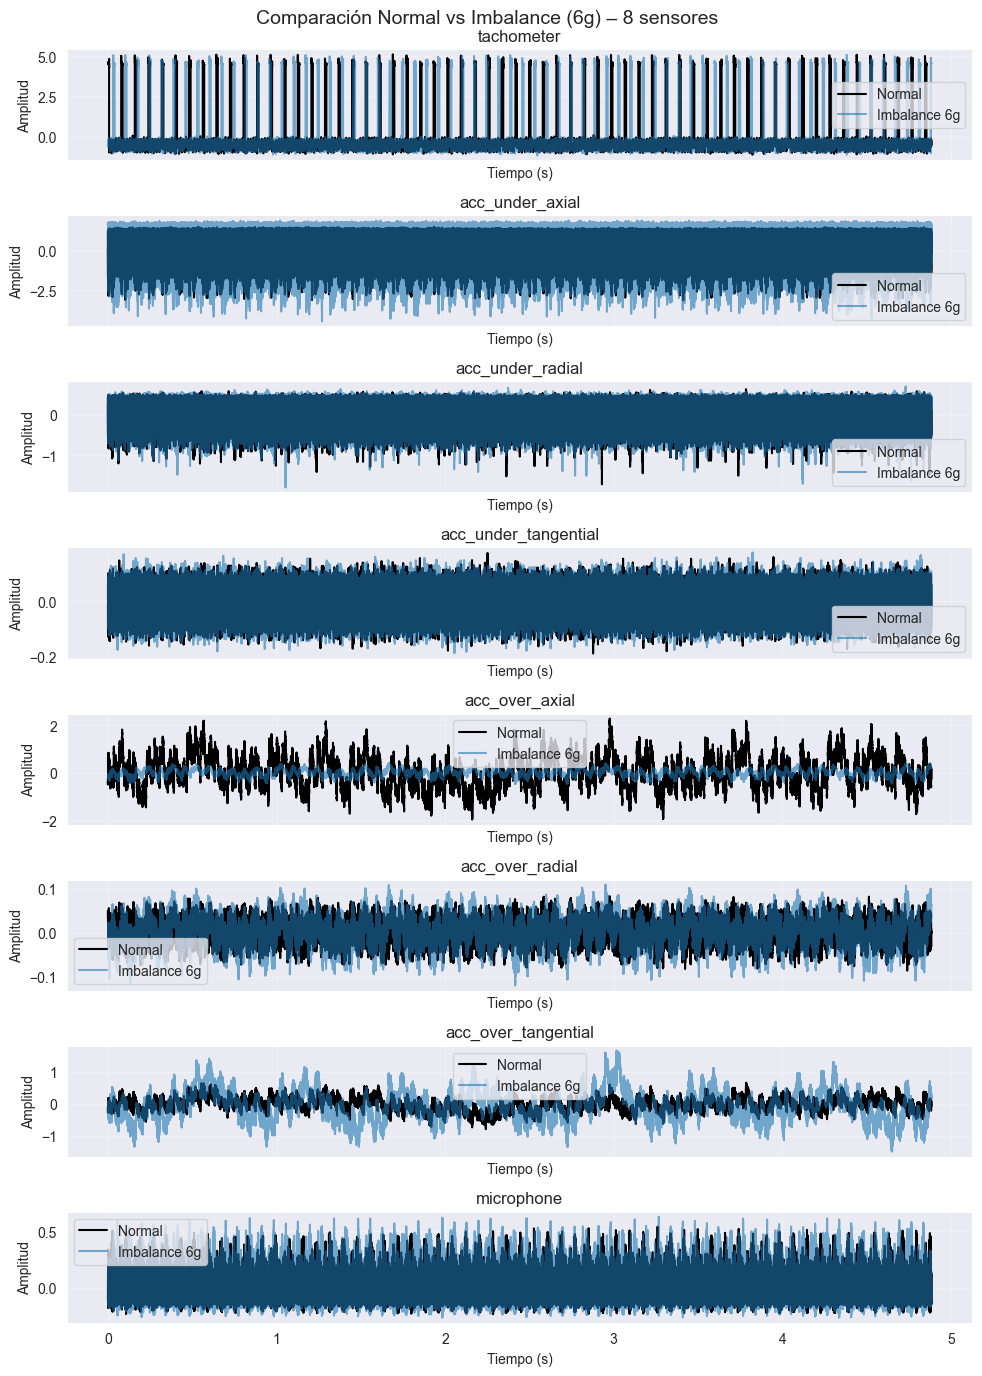

In [251]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        im_6g_139264[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Imbalance 6g"])

fig.suptitle("Comparación Normal vs Imbalance (6g) – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

In [252]:
signals_by_condition = {
    "normal": normal_12288,
    "imbalance_6g": im_6g_139264,
    "imbalance_10g": im_10g_139264,
    "imbalance_15g": im_15g_139264,
    "imbalance_20g": im_20g_139264,
    "imbalance_25g": im_25g_139264,
    "imbalance_30g": im_30g_139264,
    "imbalance_35g": im_35g_139264
}

In [253]:
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():

        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)

df_features

mean       std       rms      max      min      ptp  kurtosis  \
0   0.002930  1.585570  1.585572  5.10780 -1.12590  6.23370  4.304473   
1  -0.001632  1.598095  1.598096  5.07290 -1.16510  6.23800  4.150891   
2   0.001025  1.597937  1.597937  5.09300 -1.15910  6.25210  4.148519   
3  -0.000499  1.585841  1.585841  5.05050 -1.10060  6.15110  4.298053   
4   0.004518  1.599540  1.599546  5.11490 -1.23330  6.34820  4.125145   
..       ...       ...       ...      ...      ...      ...       ...   
59  0.012278  0.124477  0.125081  0.68336 -0.27791  0.96127  0.434290   
60  0.010893  0.112629  0.113154  0.59677 -0.25379  0.85056  0.262594   
61  0.020243  0.137205  0.138691  0.81123 -0.32248  1.13371  0.704951   
62  0.021018  0.131593  0.133261  0.75073 -0.30967  1.06040  0.487962   
63  0.014238  0.124749  0.125559  0.72627 -0.28293  1.00920  0.825647   

    skewness  zero_crossings      sensor      condition  
0   2.500403             145  tachometer         normal  
1   2.470234             149  tachometer   imbalance_6g  
2   2.469517             161  tachometer  imbalance_10g  
3   2.499302             154  tachometer  imbalance_15g  
4   2.464855             141  tachometer  imbalance_20g  
..       ...             ...         ...            ...  
59  0.826630          190997  microphone  imbalance_15g  
60  0.736041          200016  microphone  imbalance_20g  
61  0.894237          190724  microphone  imbalance_25g  
62  0.829953          195669  microphone  imbalance_30g  
63  0.983299          174086  microphone  imbalance_35g  

[64 rows x 11 columns]

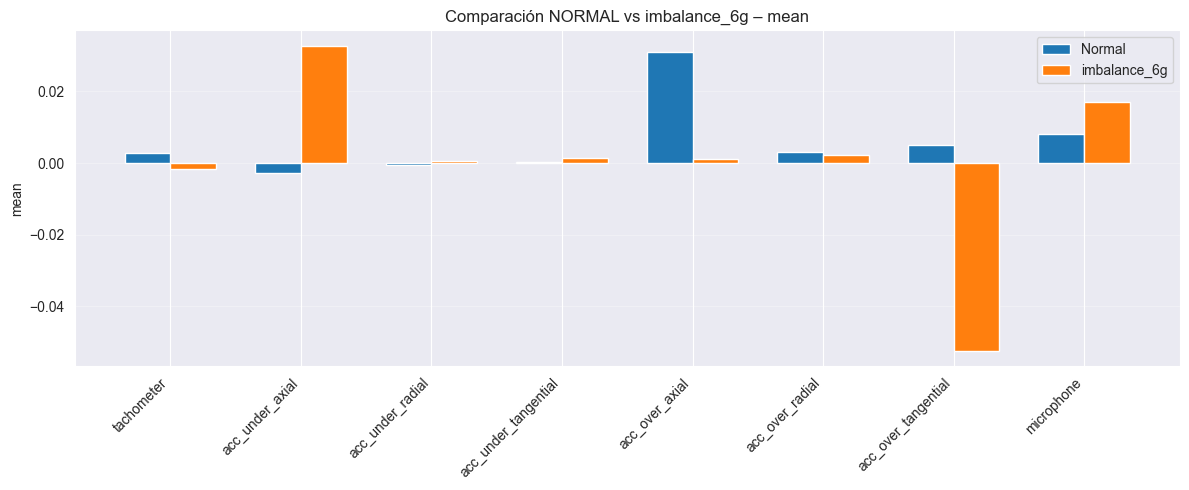

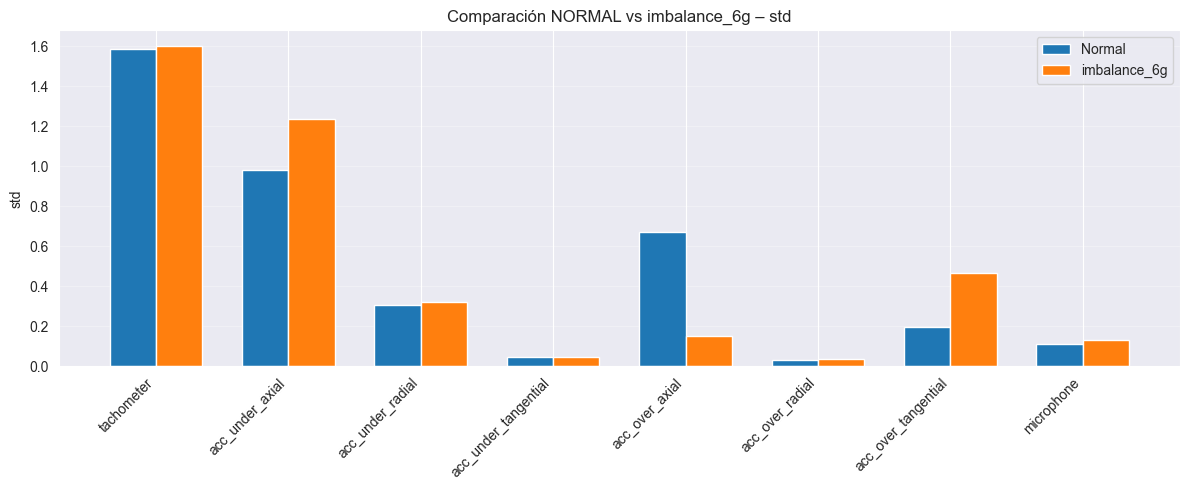

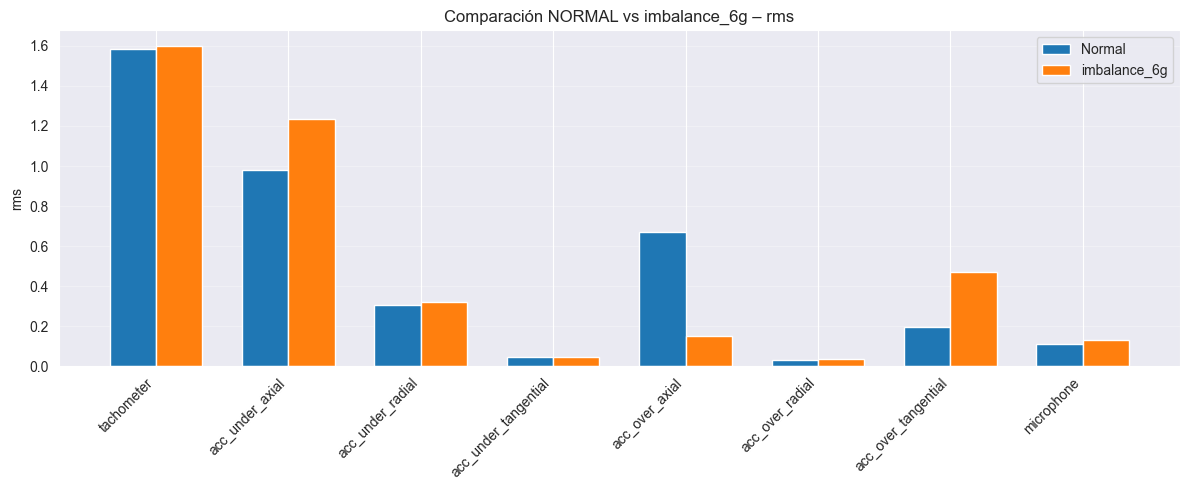

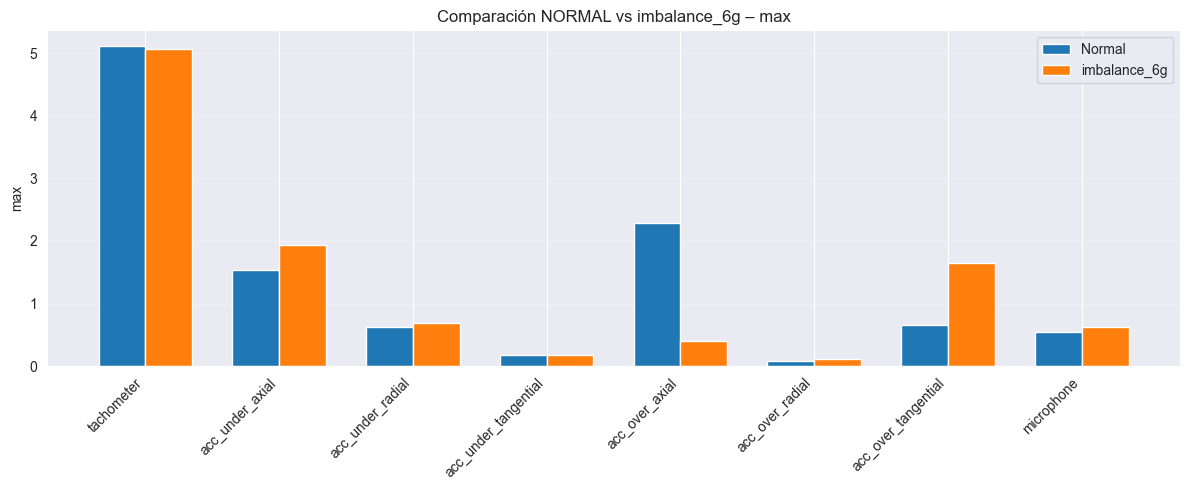

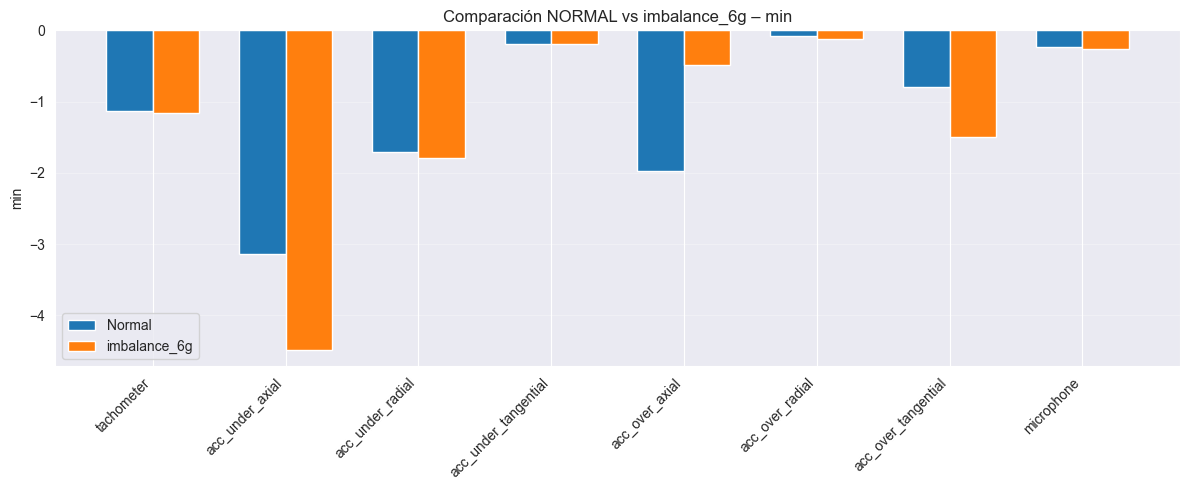

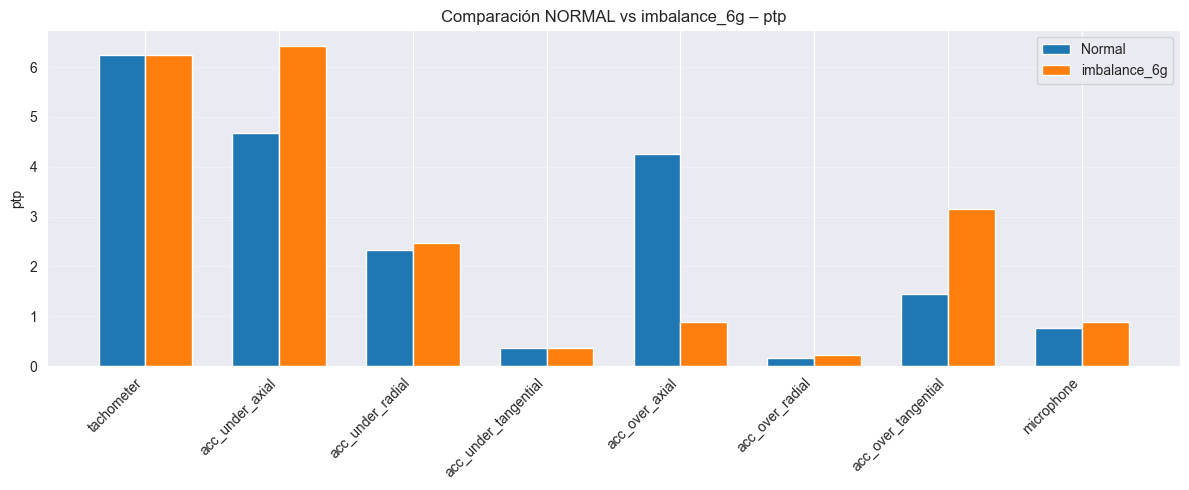

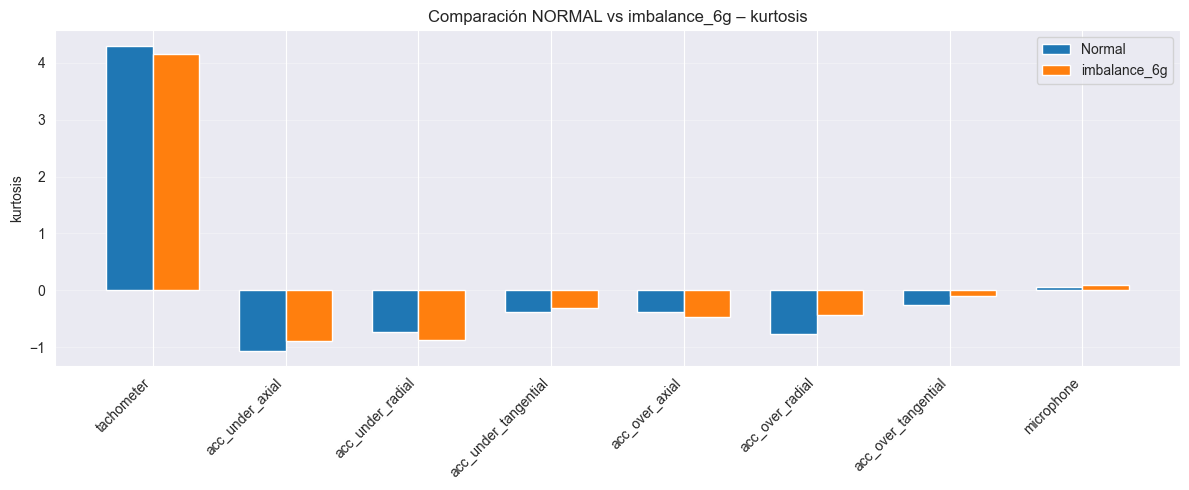

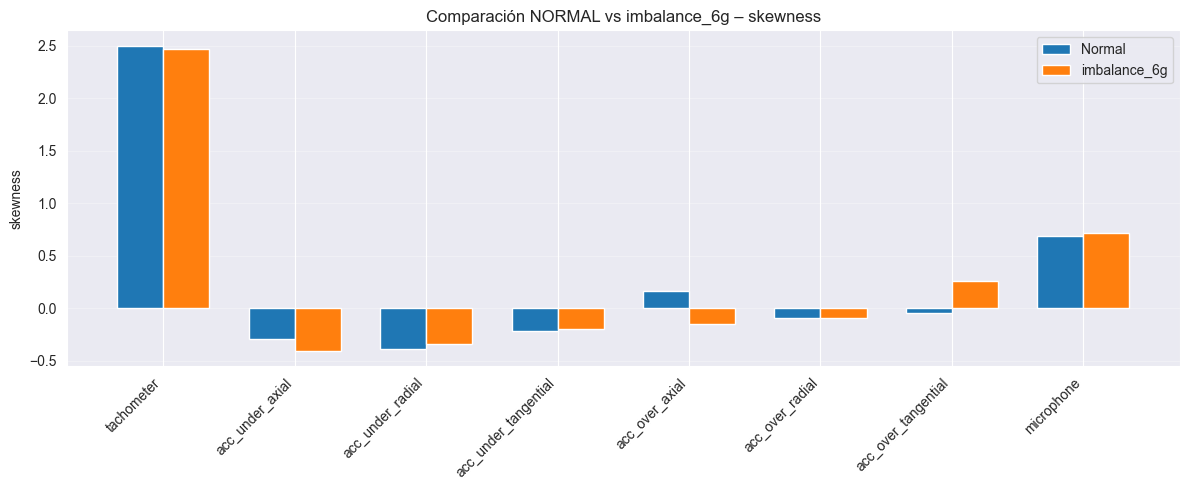

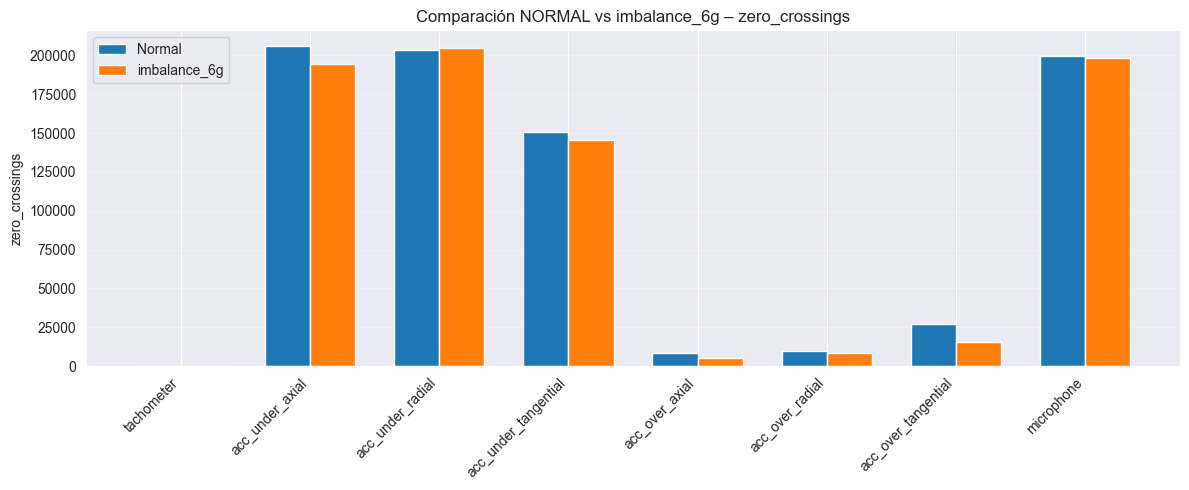

In [254]:
for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["imbalance_6g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12,5))

    plt.bar(x - width/2, normal_vals, width, label="Normal")
    plt.bar(x + width/2, imbalance_vals, width, label="imbalance_6g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs imbalance_6g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [255]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="imbalance_6g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.03542915126255199

Característica: std
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.27022434080541763

Característica: rms
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.27308925983560783

Característica: max
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.9972300000000001

Característica: min
Sensor con mayor incremento: acc_over_axial
Incremento: 1.4905499999999998

Característica: ptp
Sensor con mayor incremento: acc_under_axial
Incremento: 1.7434000000000003

Característica: kurtosis
Sensor con mayor incremento: acc_over_radial
Incremento: 0.3263074160085182

Característica: skewness
Sensor con mayor incremento: acc_over_tangential
Incremento: 0.3125247383226263

Característica: zero_crossings
Sensor con mayor incremento: acc_under_radial
Incremento: 774



# Overhang

In [256]:
# Cargar CSV SIN header y asignar nombres
ov_bf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"overhang"/"ball_fault"/"0g"/"12.9024.csv",
    header=None,
    names=sensor_names)

ov_cf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"overhang"/"cage_fault"/"0g"/"13.1072.csv",
    header=None,
    names=sensor_names)

ov_or_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"overhang"/"outer_race"/"0g"/"13.1072.csv",
    header=None,
    names=sensor_names)

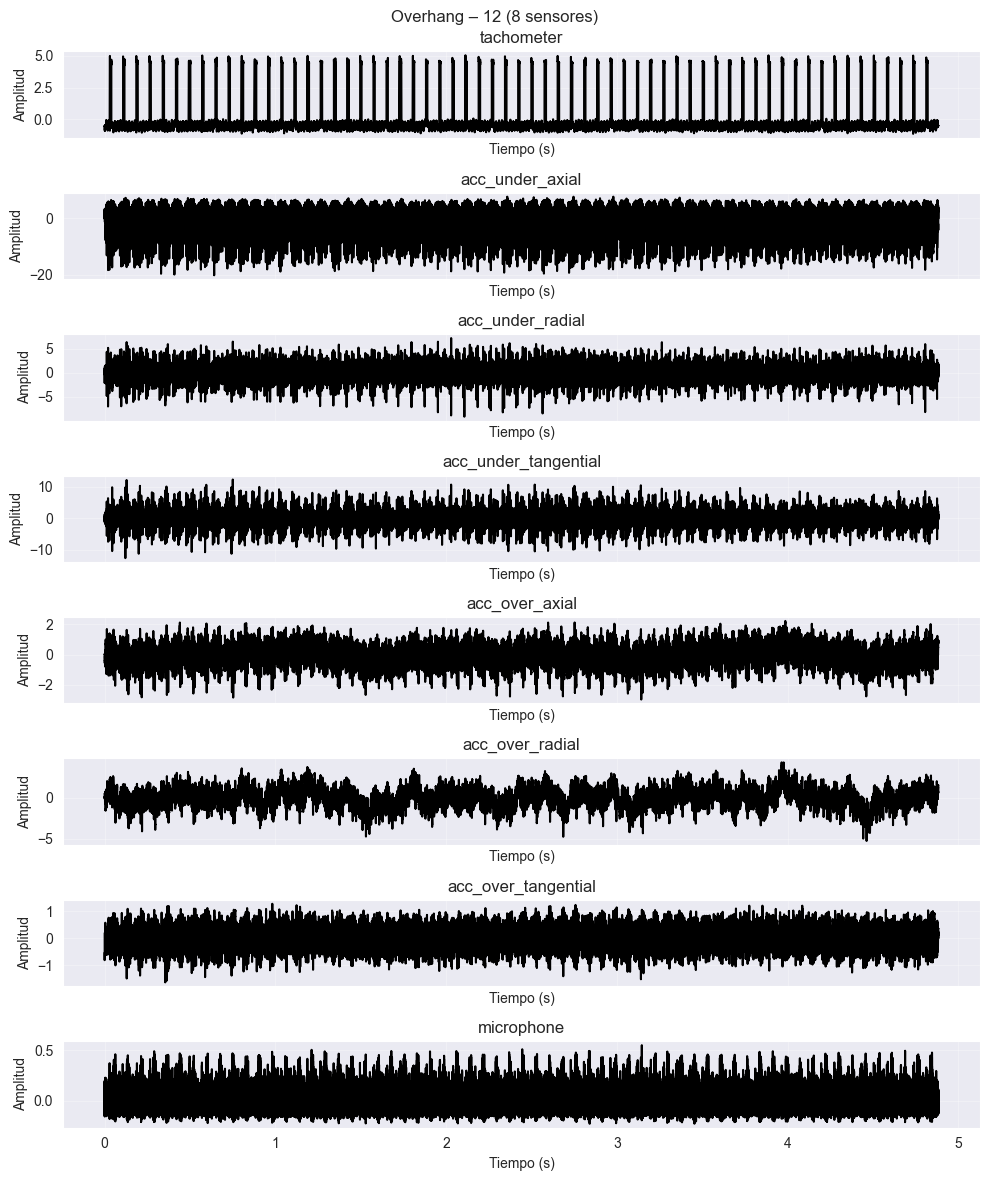

In [257]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(ov_bf_0g.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, ov_bf_0g.columns):
    run_sequence_plot(
        temporal,
        ov_bf_0g[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Overhang – 12 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs Overhang

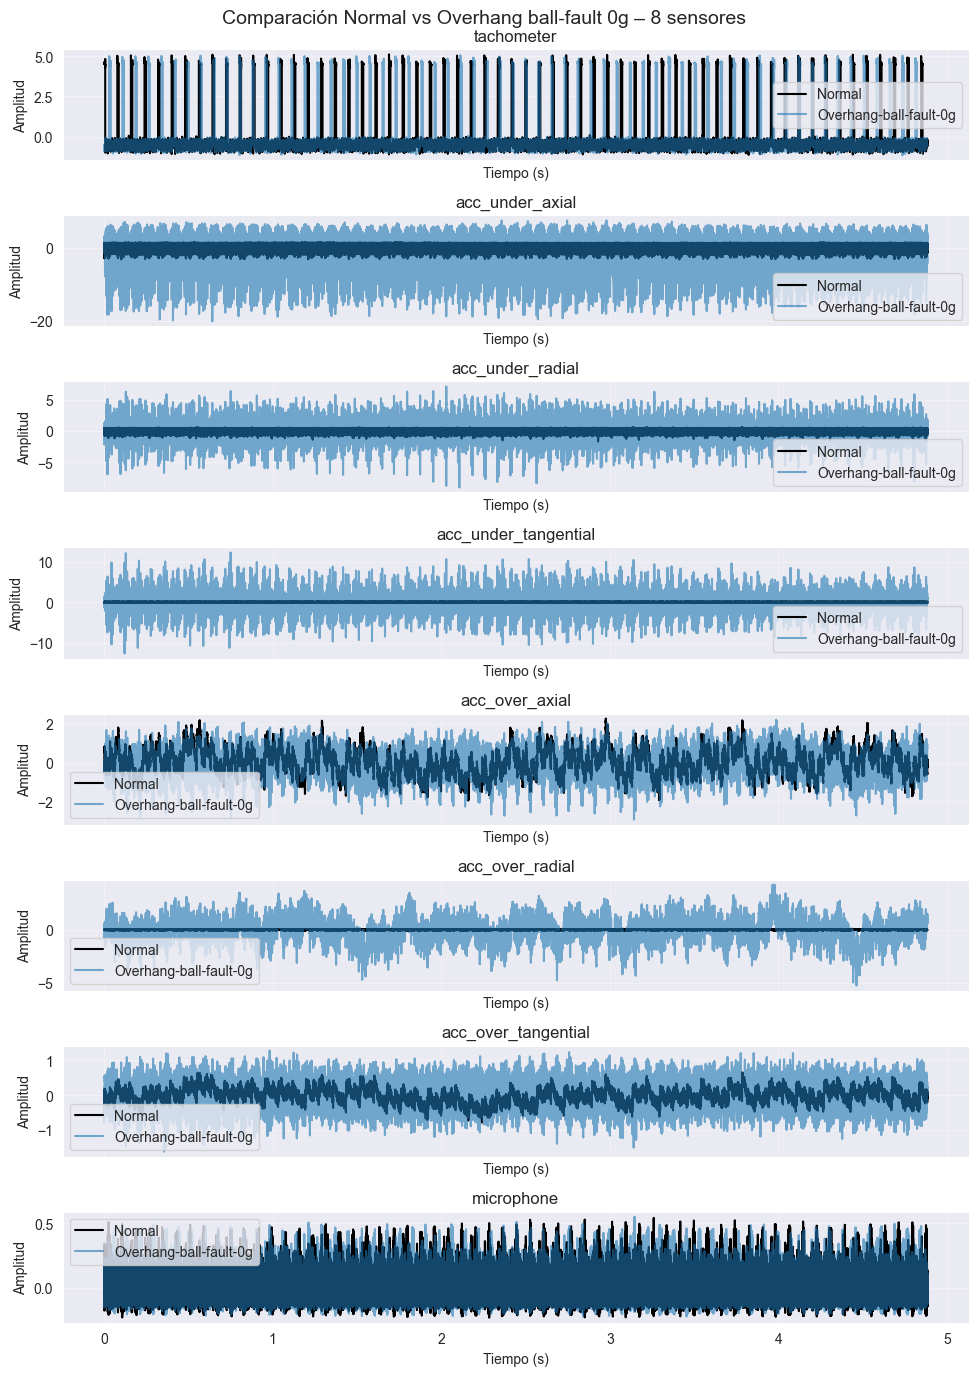

In [258]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        ov_bf_0g[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Overhang-ball-fault-0g"])

fig.suptitle("Comparación Normal vs Overhang ball-fault 0g – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

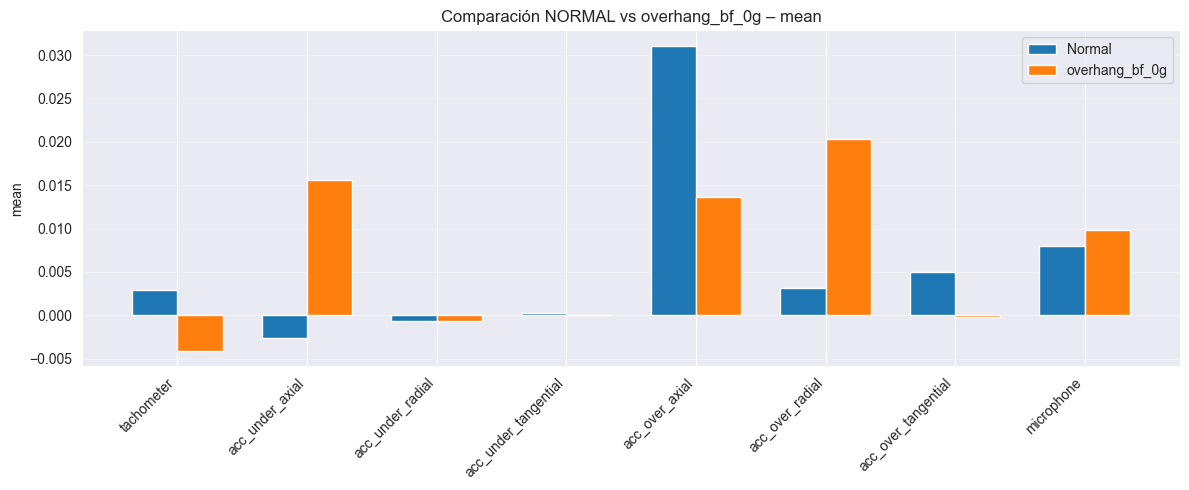

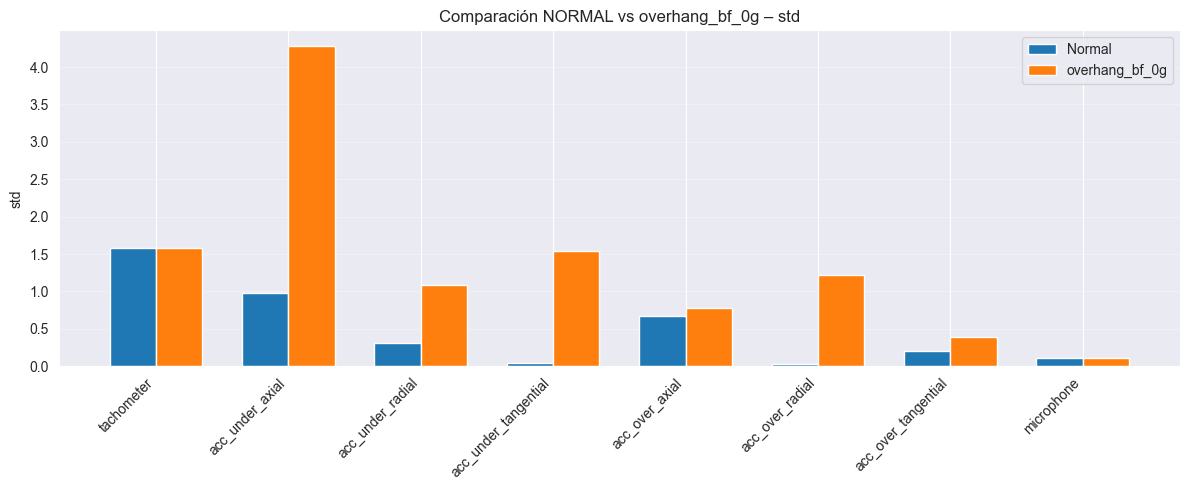

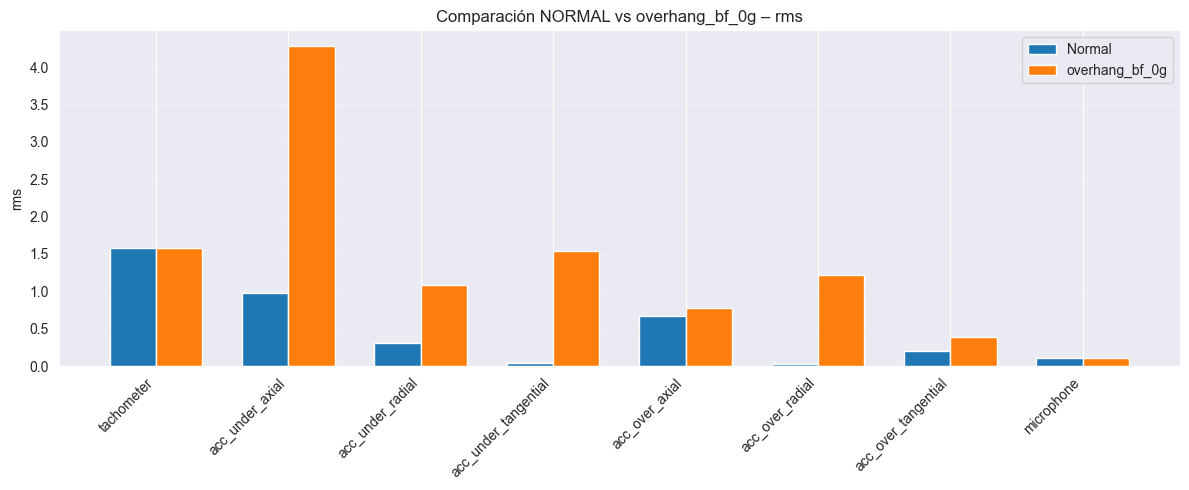

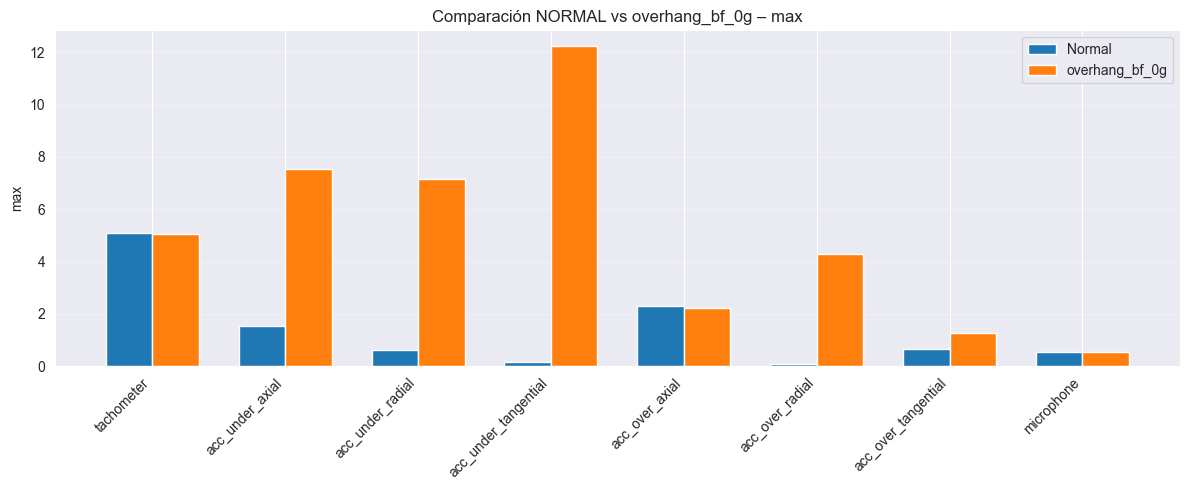

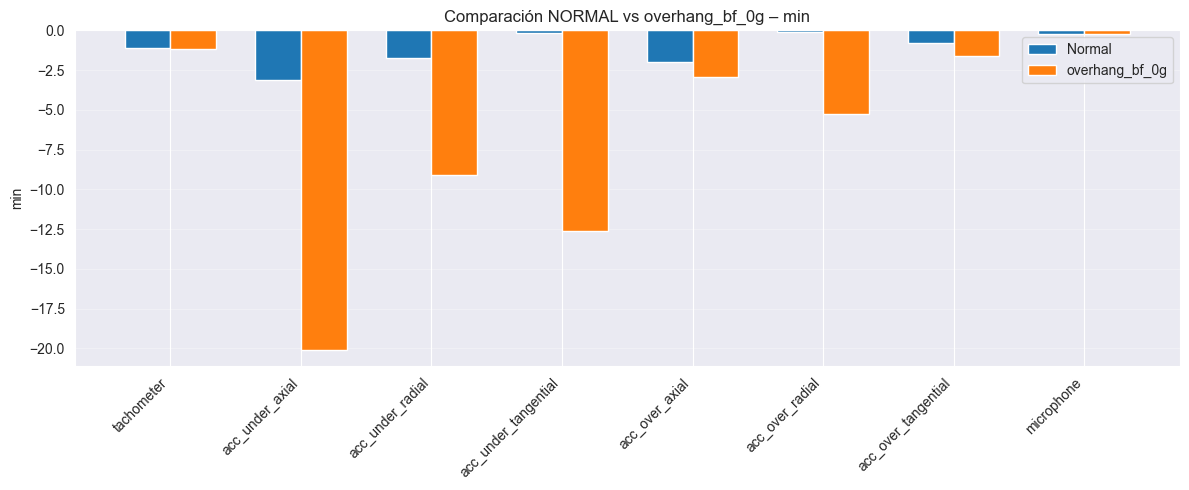

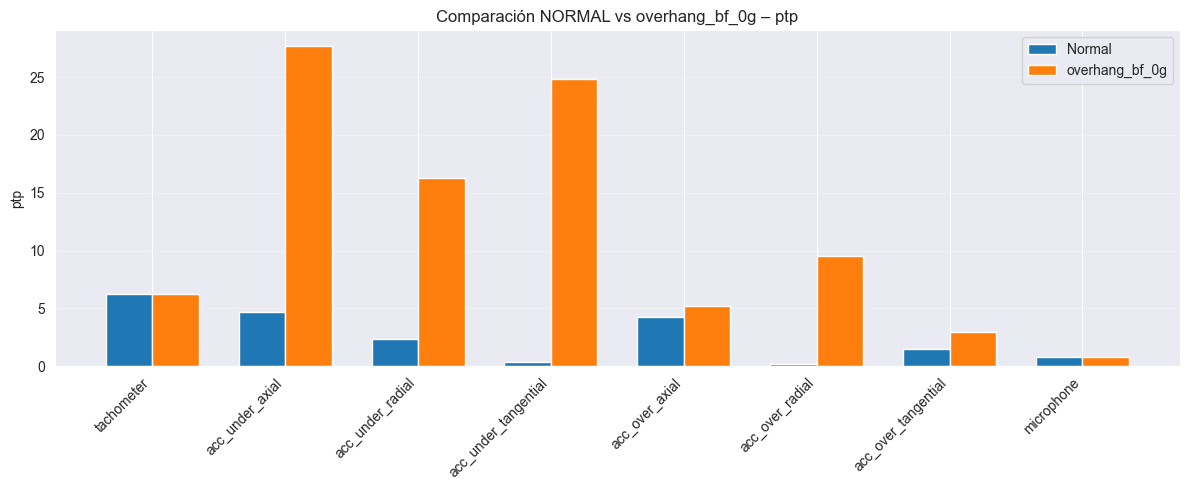

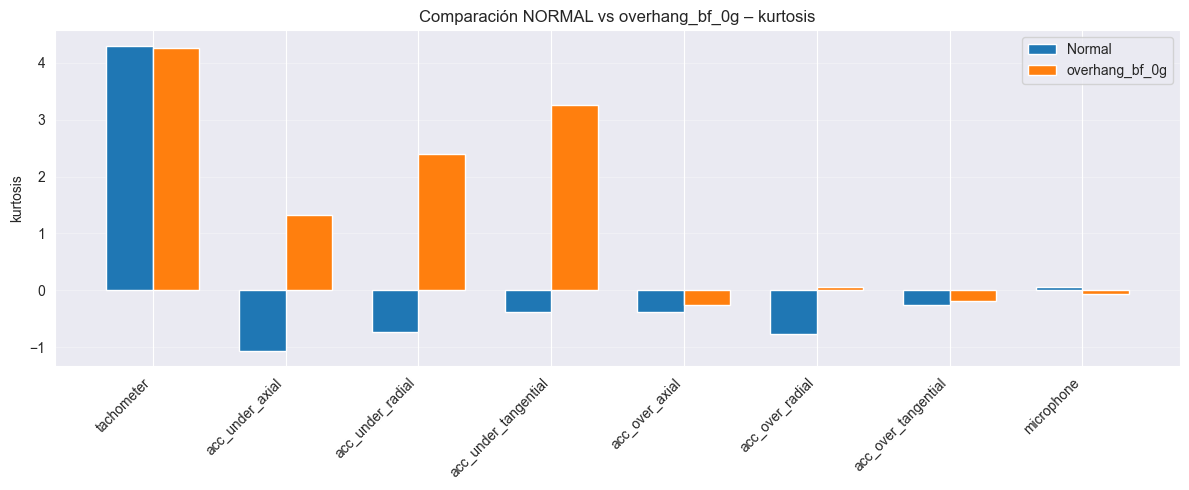

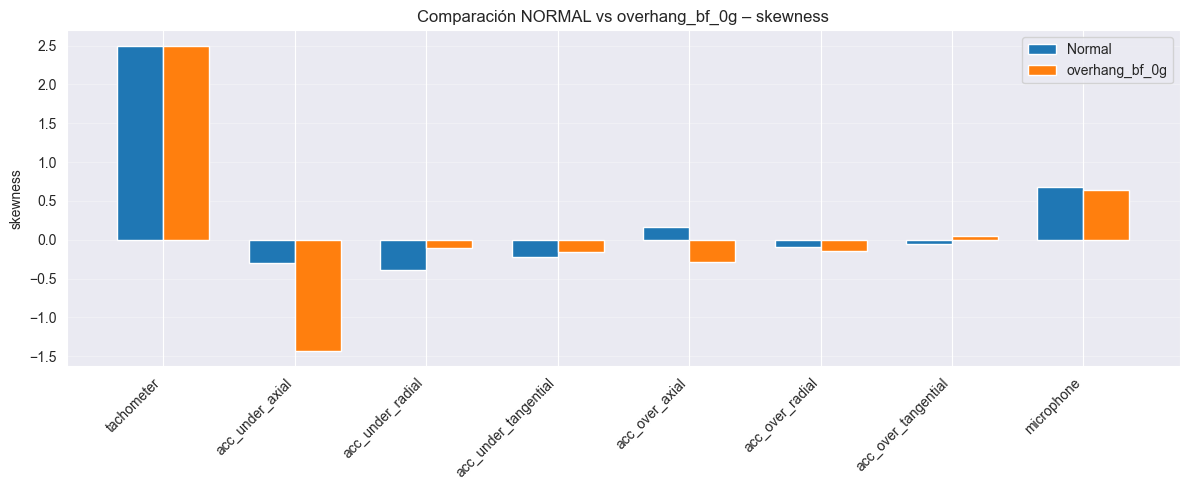

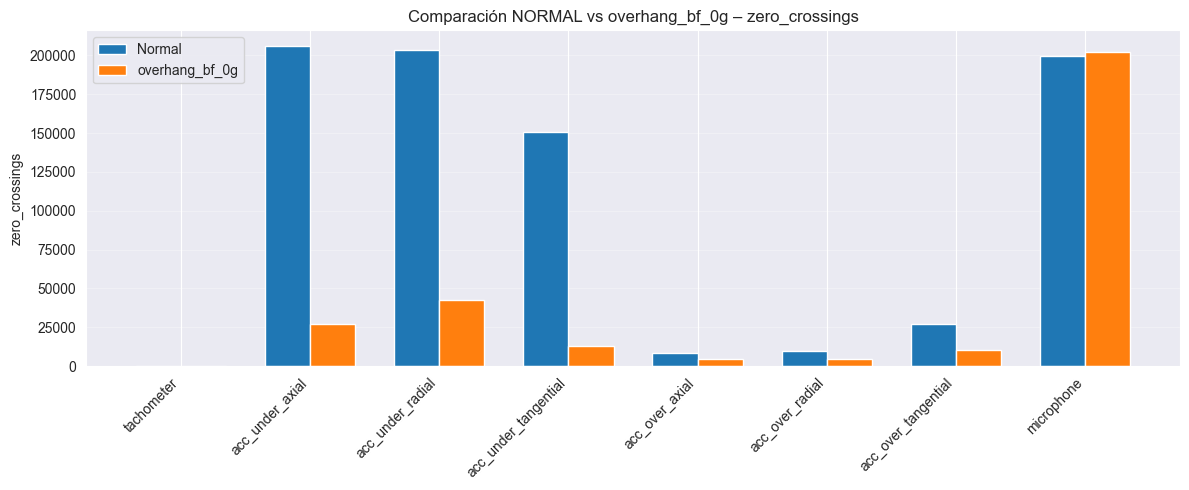

In [259]:
signals_by_condition = {
    "normal": normal_12288,
    "overhang_bf_0g": ov_bf_0g,
    "overhang_cf_0g": ov_cf_0g,
    "overhang_or_0g": ov_or_0g
}
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():
        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)

df_features

for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["overhang_bf_0g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12, 5))

    plt.bar(x - width / 2, normal_vals, width, label="Normal")
    plt.bar(x + width / 2, imbalance_vals, width, label="overhang_bf_0g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs overhang_bf_0g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [260]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="overhang_bf_0g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.018317416162845202

Característica: std
Sensor con mayor incremento: acc_under_axial
Incremento: 3.298030686525081

Característica: rms
Sensor con mayor incremento: acc_under_axial
Incremento: 3.2980557280805836

Característica: max
Sensor con mayor incremento: acc_under_tangential
Incremento: 12.05167

Característica: min
Sensor con mayor incremento: microphone
Incremento: 0.009099999999999997

Característica: ptp
Sensor con mayor incremento: acc_under_tangential
Incremento: 24.506210000000003

Característica: kurtosis
Sensor con mayor incremento: acc_under_tangential
Incremento: 3.640339314406385

Característica: skewness
Sensor con mayor incremento: acc_under_radial
Incremento: 0.29141265564067736

Característica: zero_crossings
Sensor con mayor incremento: microphone
Incremento: 2805



# Underhang

In [261]:
# Cargar CSV SIN header y asignar nombres
un_bf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"underhang"/"ball_fault"/"0g"/"13.1072.csv",
    header=None,
    names=sensor_names)

un_cf_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"underhang"/"cage_fault"/"0g"/"13.312.csv",
    header=None,
    names=sensor_names)

un_or_0g = pd.read_csv(
     PATH / "bearing_fault_detection_reduced"/"underhang"/"outer_race"/"0g"/"13.5168.csv",
    header=None,
    names=sensor_names)

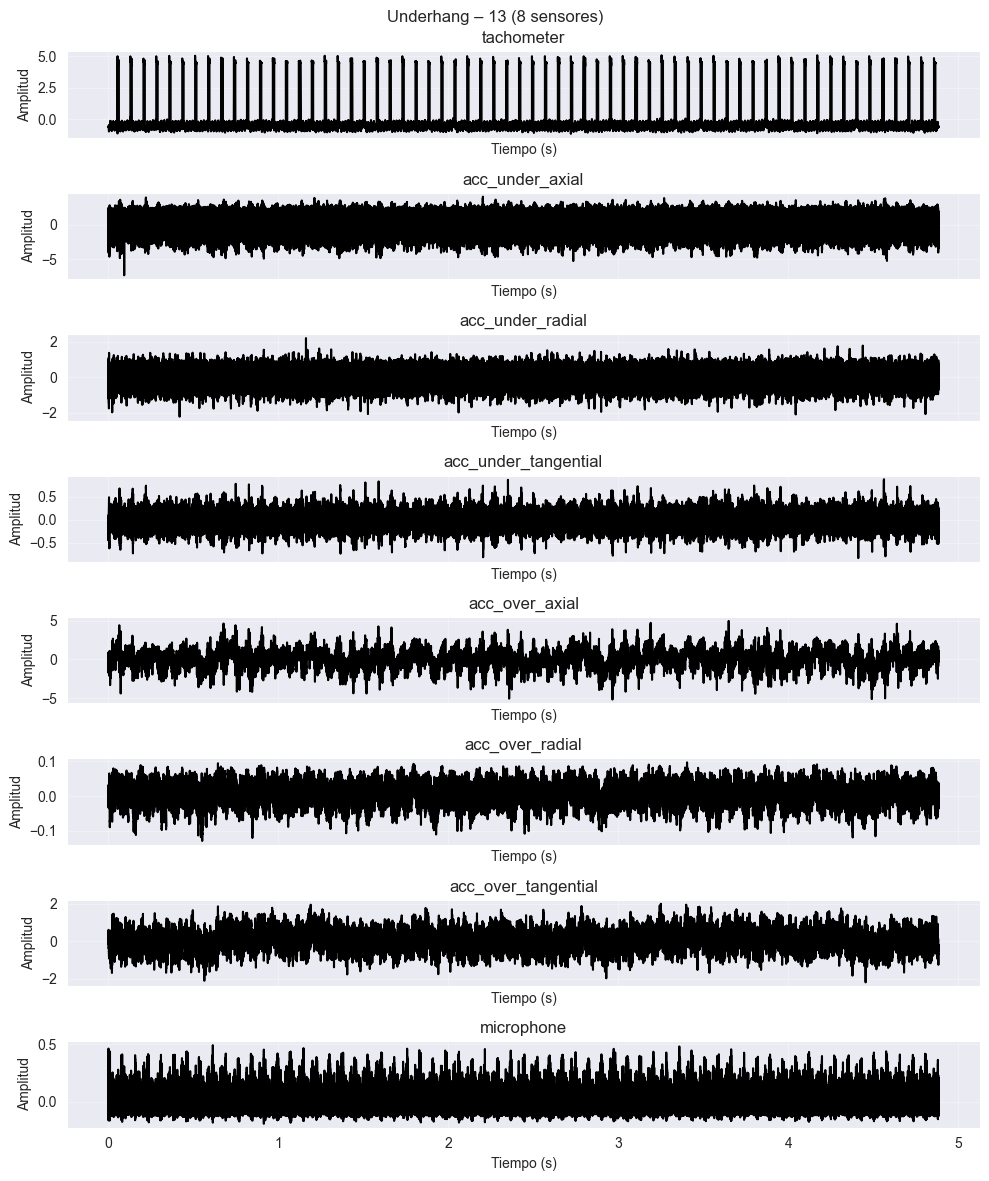

In [262]:
# Creamos una figura con tantos ejes como sensores
fig, axes = plt.subplots(
    nrows=len(un_bf_0g.columns),
    ncols=1,
    sharex=True,
    figsize=(10, 12)
)

# Funcion nuestra
for ax, col in zip(axes, un_bf_0g.columns):
    run_sequence_plot(
        temporal,
        un_bf_0g[col],
        title=col,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

fig.suptitle("Underhang – 13 (8 sensores)")
plt.tight_layout()
plt.show()

## Comparación normal vs Underhang

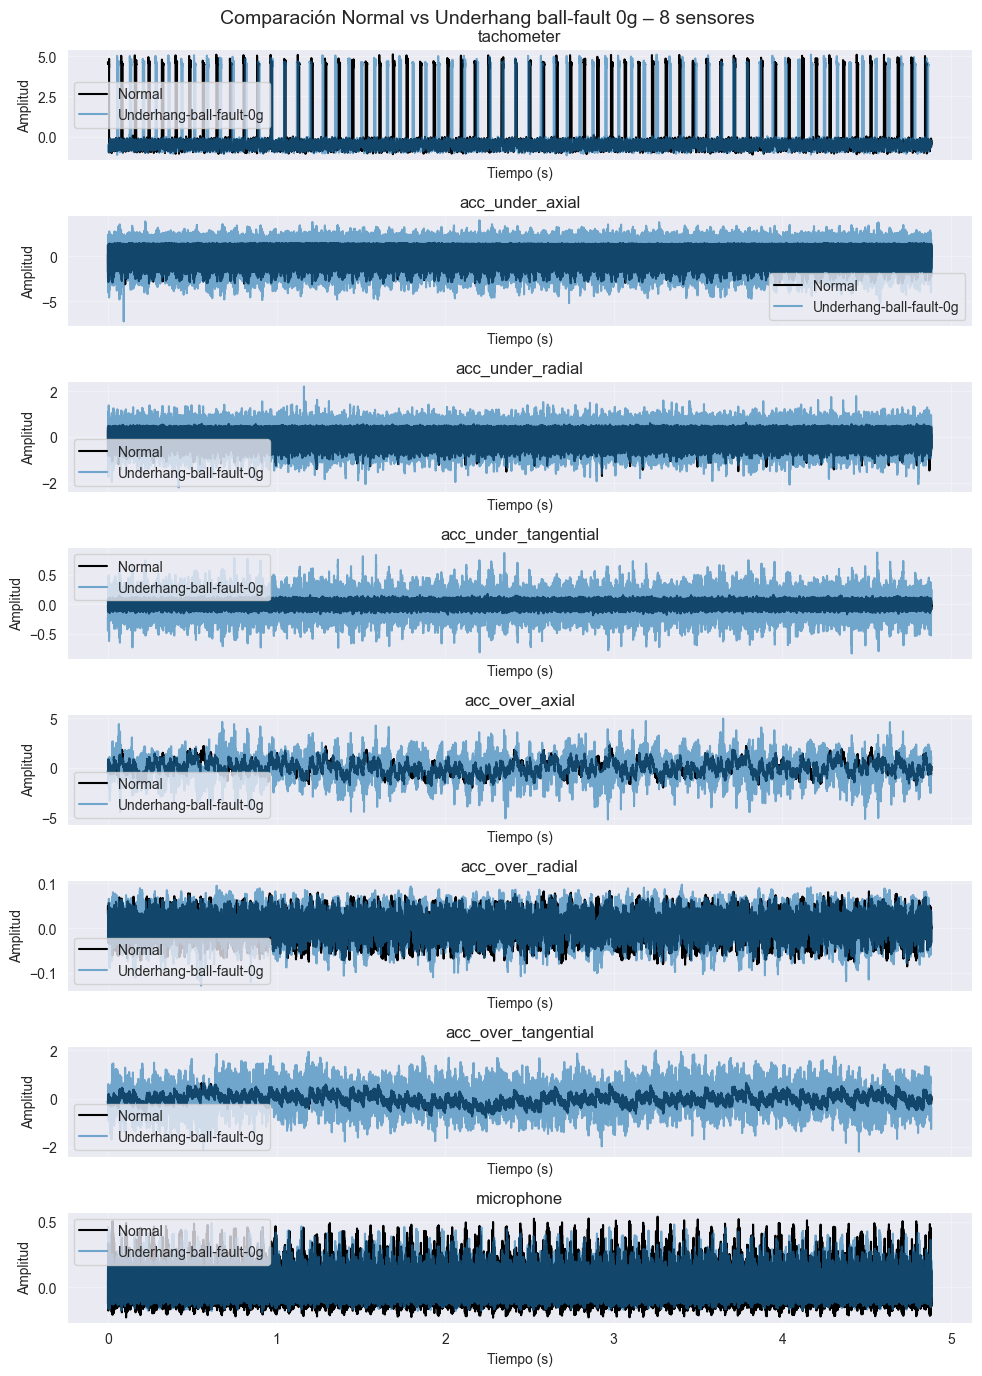

In [263]:
fig, axes = plt.subplots(
    nrows=len(sensor_names),
    ncols=1,
    sharex=True,
    figsize=(10, 14)
)

for ax, sensor in zip(axes, sensor_names):

    # Señal NORMAL (base del plot)
    run_sequence_plot(
        temporal,
        normal_12288[sensor],
        title=sensor,
        xlabel="Tiempo (s)",
        ylabel="Amplitud",
        ax=ax
    )

    # Señal superpuesta
    ax.plot(
        temporal,
        un_bf_0g[sensor],
        alpha=0.6
    )

    ax.legend(["Normal", "Underhang-ball-fault-0g"])

fig.suptitle("Comparación Normal vs Underhang ball-fault 0g – 8 sensores", fontsize=14)
plt.tight_layout()
plt.show()

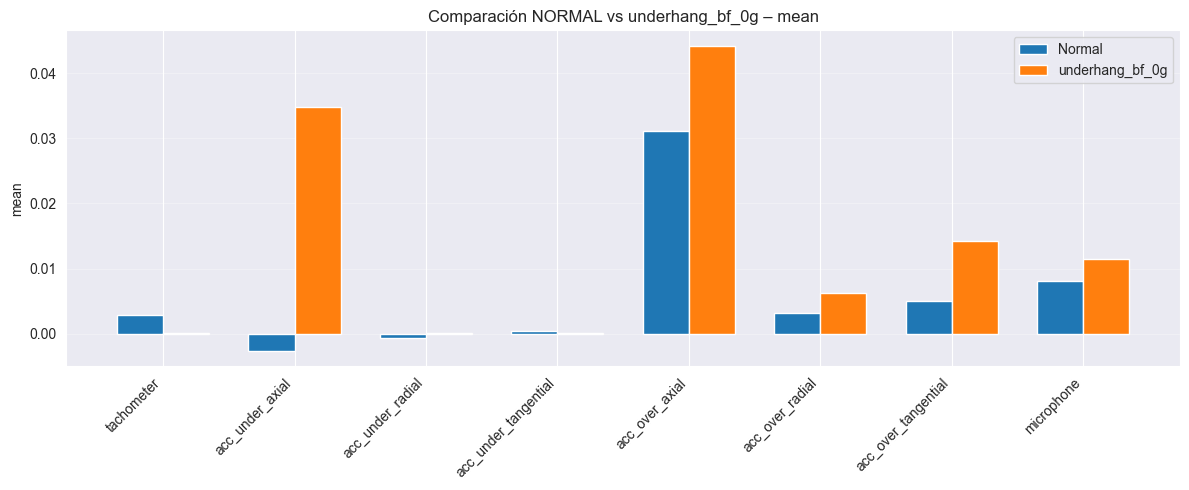

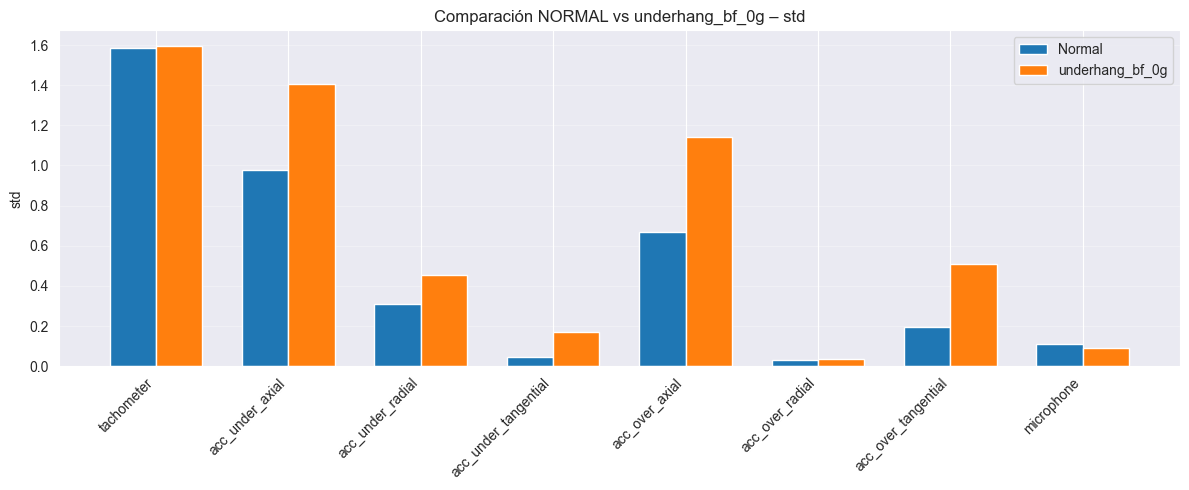

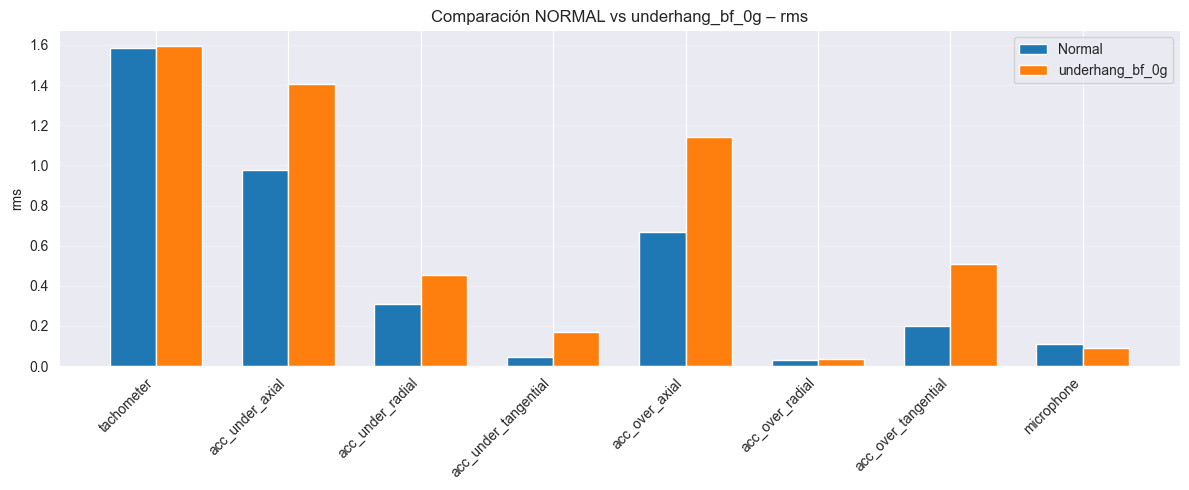

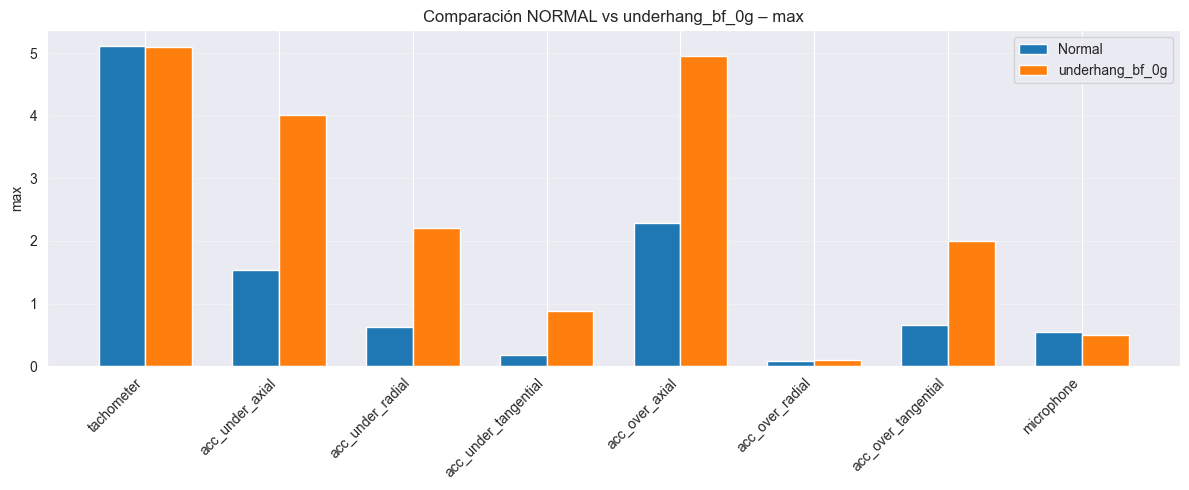

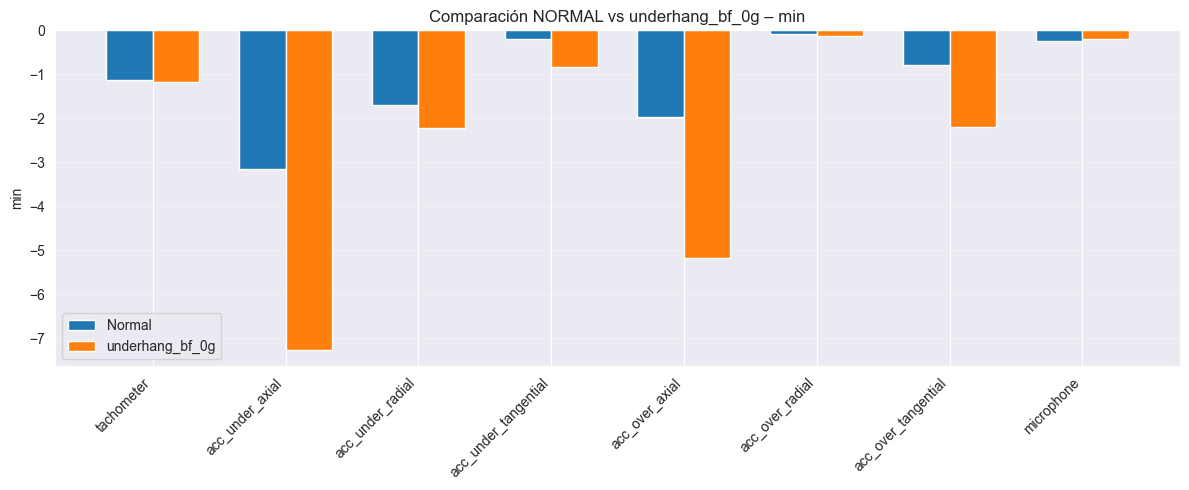

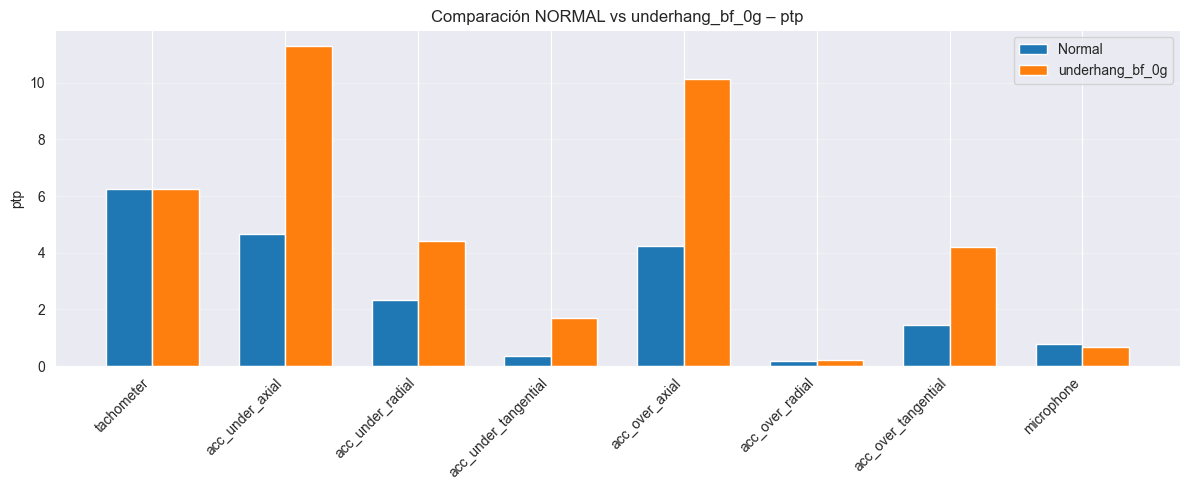

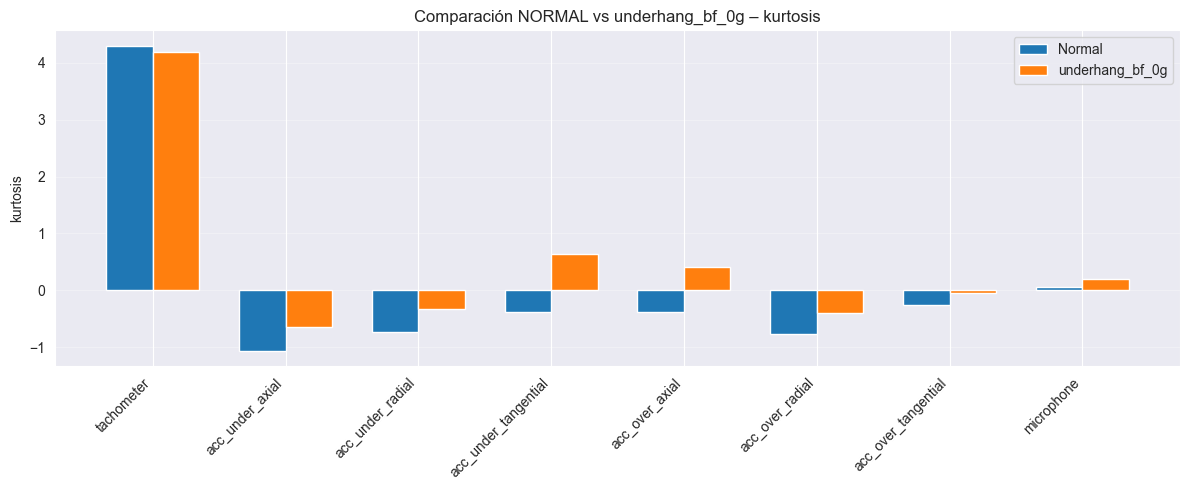

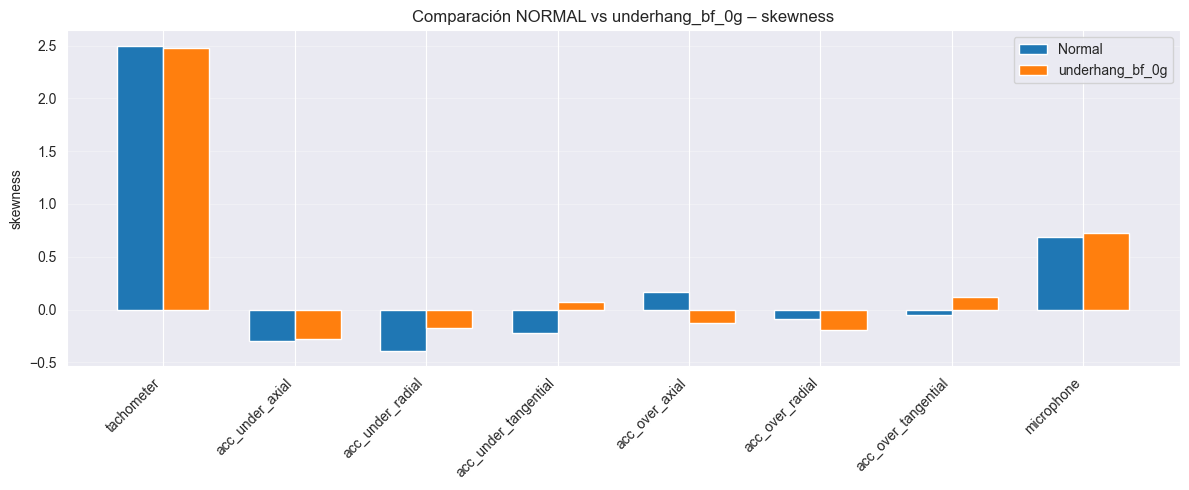

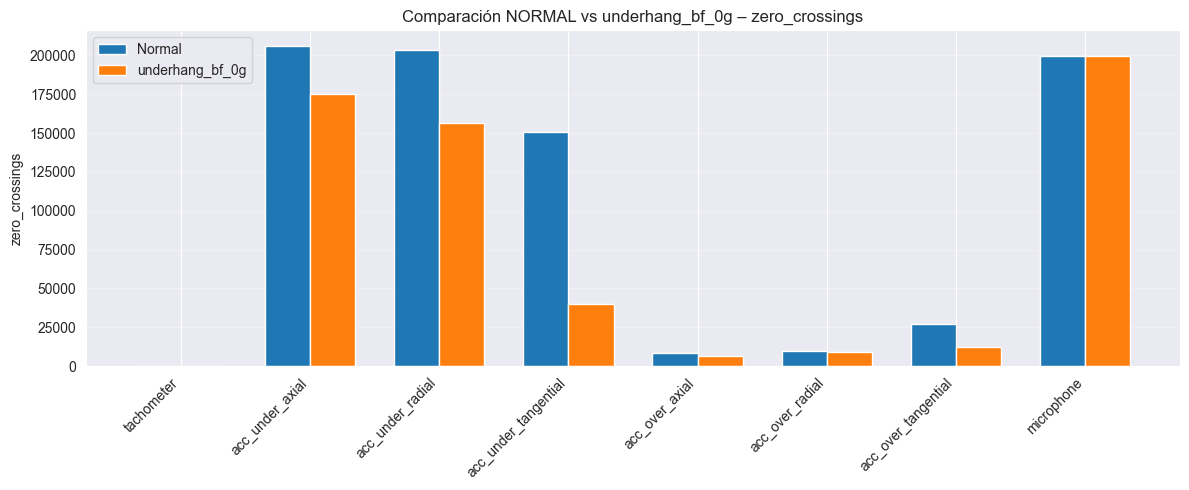

In [264]:
signals_by_condition = {
    "normal": normal_12288,
    "underhang_bf_0g": un_bf_0g,
    "underhang_cf_0g": un_cf_0g,
    "underhang_or_0g": un_or_0g,
}
rows = []

for sensor in sensor_names:
    for condition, df in signals_by_condition.items():
        feats = temporal_features(df[sensor].values)
        feats["sensor"] = sensor
        feats["condition"] = condition

        rows.append(feats)

df_features = pd.DataFrame(rows)

df_features

for feature in features:

    normal_vals = []
    imbalance_vals = []

    for sensor in sensor_names:
        df_s = df_features[
            (df_features["sensor"] == sensor)
        ].set_index("condition")

        normal_vals.append(df_s.loc["normal", feature])
        imbalance_vals.append(df_s.loc["underhang_bf_0g", feature])

    x = np.arange(len(sensor_names))
    width = 0.35

    plt.figure(figsize=(12, 5))

    plt.bar(x - width / 2, normal_vals, width, label="Normal")
    plt.bar(x + width / 2, imbalance_vals, width, label="underhang_bf_0g")

    plt.xticks(x, sensor_names, rotation=45, ha="right")
    plt.ylabel(feature)
    plt.title(f"Comparación NORMAL vs underhang_bf_0g – {feature}")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [265]:
for feature in features:

    sensor, incremento, tabla = sensor_mayor_incremento(
        df_features,
        feature=feature,
        condition_fault="underhang_bf_0g"
    )

    print("="*60)
    print(f"Característica: {feature}")
    print("Sensor con mayor incremento:", sensor)
    print("Incremento:", incremento)
    print()

Característica: mean
Sensor con mayor incremento: acc_under_axial
Incremento: 0.037492380213991996

Característica: std
Sensor con mayor incremento: acc_over_axial
Incremento: 0.47220399858871864

Característica: rms
Sensor con mayor incremento: acc_over_axial
Incremento: 0.4723401196930096

Característica: max
Sensor con mayor incremento: acc_over_axial
Incremento: 2.6727

Característica: min
Sensor con mayor incremento: microphone
Incremento: 0.040449999999999986

Característica: ptp
Sensor con mayor incremento: acc_under_axial
Incremento: 6.6114

Característica: kurtosis
Sensor con mayor incremento: acc_under_tangential
Incremento: 1.0085941140913275

Característica: skewness
Sensor con mayor incremento: acc_under_tangential
Incremento: 0.29018921285606347

Característica: zero_crossings
Sensor con mayor incremento: tachometer
Incremento: 9

